# A3. GesterRecognizer - Jae Dong Hwang

Note: Left code and some instructions as is to help me review the final notebook.
Two libraries that I used addtion to the frameworks given are `fastdtw` and `signal_aligment`

## Slide Deck: https://docs.google.com/presentation/d/1BPCmzwVSpHn_2iywnwoaXmzQHLDp7wddKTr5WpTEIiw/edit?usp=sharing

# Imports

In [8]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp
from scipy import signal
import random
import os

# We wrote this gesturerec package for the class
# It provides some useful data structures for the accelerometer signal
# and running experiments so you can focus on writing classification code, 
# evaluating your solutions, and iterating 
import gesturerec.utility as grutils
import gesturerec.data as grdata
import gesturerec.gesturestream as grstream
from gesturerec.data import SensorData
from gesturerec.data import GestureSet
from gesturerec.experiments import Experiments
from gesturerec.experiments import ClassificationResults
from gesturerec.experiments import TrialClassificationResult
from gesturerec.signal_alignment import chisqr_align, phase_align
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.ndimage import shift
from collections import defaultdict

## Experiment Name

In [87]:
DEFAULT_EXP_NAME = 'Jon'

# Load the data

In [88]:
# Load the data
#root_gesture_log_path = './GestureLogs'
root_gesture_log_path = '/Users/haujd98/Downloads/GestureLogs'

print("Found the following gesture log sub-directories")
print(grutils.get_immediate_subdirectories(root_gesture_log_path))

gesture_log_paths = grutils.get_immediate_subdirectories(root_gesture_log_path)
map_gesture_sets = dict()
selected_gesture_set = None

for gesture_log_path in gesture_log_paths:
    path_to_gesture_log = os.path.join(root_gesture_log_path, gesture_log_path)
    print("Creating a GestureSet object for path '{}'".format(path_to_gesture_log))
    gesture_set = GestureSet(path_to_gesture_log)
    gesture_set.load()
    map_gesture_sets[gesture_set.name] = gesture_set

if selected_gesture_set is None:
    # Since we load multiple gesture sets and often want to just visualize and explore
    # one set, in particular, we set a selected_gesture_set variable here
    # Feel free to change this
    #selected_gesture_set = get_random_gesture_set(map_gesture_sets)
    selected_gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, DEFAULT_EXP_NAME)
    if selected_gesture_set is None:
        # if the selected gesture set is still None
        selected_gesture_set = grdata.get_random_gesture_set(map_gesture_sets);

print("The selected gesture set:", selected_gesture_set)



Found the following gesture log sub-directories
['NickGestures', 'NanGestures', 'StacyGestures', 'AnjaliGestures', 'Paf2Gestures', 'AGestures', 'ThweidGestures', 'JaeHGestures', 'DustinGestures', 'JonGestures', 'MattCGestures', 'MikaelGestures', 'AlexisGestures', 'ShaunGestures', 'SamuelRGestures', 'JustinGestures', 'JasonGestures', 'NeilGestures', 'JuliaBGestures', 'BryanGestures', 'ClayGestures', 'WolfsonGestures', 'NooseGestures', 'EmmaGestures', 'BrettGestures']
Creating a GestureSet object for path '/Users/haujd98/Downloads/GestureLogs/NickGestures'
Found 55 csv files in /Users/haujd98/Downloads/GestureLogs/NickGestures
Found 11 gestures
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Drinking Coffee'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'At Rest'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Midair 'S''
Found 5 tri

Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Shake'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Custom'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Baseball Throw'
Max trial length across all gesture is 'At Rest' Trial 4 with 506 sensor events.
Avg samples/sec across 55 sensor files: 84.0
Avg sample length across 55 sensor files: 2.3s

Creating a GestureSet object for path '/Users/haujd98/Downloads/GestureLogs/MikaelGestures'
Found 55 csv files in /Users/haujd98/Downloads/GestureLogs/MikaelGestures
Found 11 gestures
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Custom'
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Backhand Tennis'
Found

Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair Counter-clockwise 'O''
Max trial length across all gesture is 'Baseball Throw' Trial 4 with 437 sensor events.
Avg samples/sec across 55 sensor files: 91.2
Avg sample length across 55 sensor files: 3.2s

Creating a GestureSet object for path '/Users/haujd98/Downloads/GestureLogs/EmmaGestures'
Found 55 csv files in /Users/haujd98/Downloads/GestureLogs/EmmaGestures
Found 11 gestures
Found 5 trials for 'Midair Counter-clockwise 'O''
Found 5 trials for 'Shake'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Star'
Found 5 trials for 'Midair Zorro 'Z''
Found 5 trials for 'Midair Clockwise 'O''
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Underhand Bowling'
Found 5 trials for 'Midair 'S''
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'At Rest'
Max trial length across all gesture is 'Star' Trial 3 with 170 sensor events.
Avg 

The `map_gesture_sets` is a `dict` object and is our primary data structure: it maps gesture dir names to `GestureSet` objects. There's truly nothing special here. But we realize our data structures do require a learning ramp-up. Let's iterate through the GestureSets.

In [197]:
print(f"We have {len(map_gesture_sets)} gesture sets:")
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print(f" {gesture_set_name} with {len(gesture_set.get_all_trials())} trials")

# Feel free to change the selected_gesture_set. It's just a convenient variable
# to explore one gesture set at a time
print(f"The selected gesture set is: {selected_gesture_set.name}")

We have 25 gesture sets:
 NickGestures with 55 trials
 NanGestures with 55 trials
 StacyGestures with 55 trials
 AnjaliGestures with 55 trials
 Paf2Gestures with 55 trials
 AGestures with 55 trials
 ThweidGestures with 55 trials
 JaeHGestures with 55 trials
 DustinGestures with 55 trials
 JonGestures with 55 trials
 MattCGestures with 55 trials
 MikaelGestures with 55 trials
 AlexisGestures with 55 trials
 ShaunGestures with 55 trials
 SamuelRGestures with 55 trials
 JustinGestures with 55 trials
 JasonGestures with 55 trials
 NeilGestures with 55 trials
 JuliaBGestures with 55 trials
 BryanGestures with 55 trials
 ClayGestures with 55 trials
 WolfsonGestures with 55 trials
 NooseGestures with 55 trials
 EmmaGestures with 55 trials
 BrettGestures with 55 trials
The selected gesture set is: JaeHGestures


# Preprocess the data

I included the configurations and accuracy results from the experiments in ppt file. I basically tried different types of preprocessing with my algorithms and commented out what didn't work. I also added the `detrending` signals to the trial object so that I can use those in different algorithm.

In [91]:
def preprocess_signal(s):
    '''Preprocesses the signal'''
    """
    I have 
    """
    mean_filter_window_size = 10
    processed_signal = np.convolve(s, 
                                   np.ones((mean_filter_window_size,))/mean_filter_window_size, 
                                   mode='valid')
    #processed_signal = signal.detrend(processed_signal)  # detrending
    #processed_signal = processed_signal - np.mean(processed_signal)  # offset translation
    #processed_signal = (processed_signal - np.mean(processed_signal)) / np.std(processed_signal)  # amplitude scaling
    return processed_signal
       


def preprocess_trial(trial):
    '''Processess the given trial'''
    trial.accel.x_p = preprocess_signal(trial.accel.x)
    trial.accel.y_p = preprocess_signal(trial.accel.y)
    trial.accel.z_p = preprocess_signal(trial.accel.z)
    trial.accel.mag_p = preprocess_signal(trial.accel.mag)
    trial.accel.x_p_dt = signal.detrend(trial.accel.x_p)  # detrended
    trial.accel.y_p_dt = signal.detrend(trial.accel.y_p)  # detrended
    trial.accel.z_p_dt = signal.detrend(trial.accel.z_p)  # detrended
    trial.accel.x_p_as = (trial.accel.x_p - np.mean(trial.accel.x_p)) / np.std(trial.accel.x_p) # amplitude scaling
    trial.accel.y_p_as = (trial.accel.y_p - np.mean(trial.accel.y_p)) / np.std(trial.accel.y_p) # amplitude scaling
    trial.accel.z_p_as = (trial.accel.z_p - np.mean(trial.accel.z_p)) / np.std(trial.accel.z_p) # amplitude scaling
    
for gesture_set in map_gesture_sets.values():
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        for trial in trials:
            preprocess_trial(trial)

# Explore the data

I added two additional visualization and one of them is comparison between original and detrended one. I ended up using the *detrending* preprocessing so it was worth to visualize.

## Plot a random gesture
Let's start by plotting the `x`, `y`, `z` and `mag` for all the trials of a random gesture for the `selected_gesture_set`

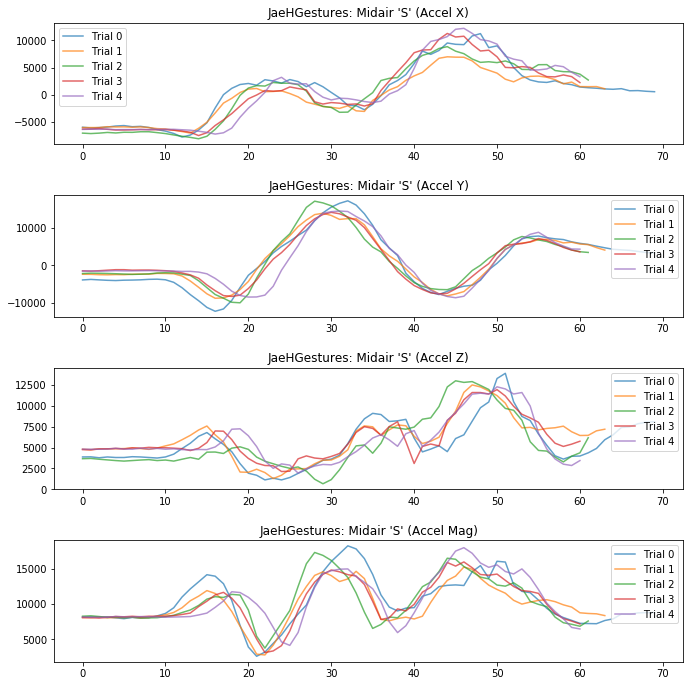

In [199]:
# For example, 
rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(4, figsize=(10, 10)) #figsize is width, height
fig.tight_layout(pad=3) # add vertical spacing
gesture_trials = selected_gesture_set.get_trials_for_gesture(rand_gesture_name)
trial_num = 0
for trial in gesture_trials:
    axes[0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trial_num))
    axes[1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trial_num))
    axes[2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trial_num))
    axes[3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trial_num))
    trial_num = trial_num + 1

# set the title and show the legend
axes[0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel X)")
axes[0].legend();

axes[1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Y)")
axes[1].legend();

axes[2].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Z)")
axes[2].legend();

axes[3].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (Accel Mag)")
axes[3].legend();

## Plot raw and preprocessed signal

In [200]:
# New Visualization - raw, convolved, detrended.
rand_gesture_name = selected_gesture_set.get_random_gesture_name()

# We'll make a 1x2 grid of plots, so pass 1,2 to subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 5)) #figsize is width, height
rand_trial = selected_gesture_set.get_random_trial_for_gesture(rand_gesture_name)

axes[0][0].plot(rand_trial.accel.x, alpha=0.7, label="x")
axes[0][0].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel x)")
axes[0][0].plot(rand_trial.accel.x_p, alpha=0.7, label="x processed")
axes[0][0].legend()

axes[1][0].plot(rand_trial.accel.x_p_as, alpha=0.7, label="x amp. scaled")
axes[1][0].legend()

axes[0][1].plot(rand_trial.accel.y, alpha=0.7, label="y")
axes[0][1].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel y)")
axes[0][1].plot(rand_trial.accel.y_p, alpha=0.7, label="y processed")
axes[0][1].legend()

axes[1][1].plot(rand_trial.accel.y_p_as, alpha=0.7, label="y amp. scaled")
axes[1][1].legend()

axes[0][2].plot(rand_trial.accel.z, alpha=0.7, label="z")
axes[0][2].set_title(selected_gesture_set.name + ": " + rand_gesture_name + " (accel z)")
axes[0][2].plot(rand_trial.accel.z_p, alpha=0.7, label="z processed")
axes[0][2].legend()

axes[1][2].plot(rand_trial.accel.z_p_as, alpha=0.7, label="z amp. scaled")
axes[1][2].legend()


Error in callback <function flush_figures at 0x120fd7290> (for post_execute):


KeyboardInterrupt: 

# Classification experiments

Start analyzing and comparing these gesture signals.Think about:
- What patterns do you see in the data?
- What kind of filtering might be useful?
- How can you best align the signals for comparison? (e.g., hint: scroll down to see the Euclidean distance comparisons)
- What kind of signal transforms might be useful? (e.g., ffts, derivative waveforms)
- What is the simplest way we can compare two signals?


## K-Fold Cross Validation Methods

I implemented the K-Fold algorithm as below. I used the `random` library to pick the bin index and trial index randomly. The kfolds validated using `check_folds` and `print_folds`.

In [5]:
# The k-fold cross validation methods
import random
import random
def generate_kfolds(num_folds, gesture_set, seed=None):
    '''
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments)
    
    num_folds : the number of folds
    gesture_set : the gesture set for splitting into k-folds
    seed : an integer seed value (pass in the same seed value to get the same split across multiple executions)
    '''
    
    # Quick check to make sure that there are numFolds of gesture trials for each gesture
    for gesture_name, trials in gesture_set.map_gestures_to_trials.items():
        if num_folds != len(trials):
            raise ValueError("For the purposes of this assignment, the number of folds={} must equal the number of trials for each gesture. Gesture '{}' has {} trials"
                             .format(num_folds, gesture_name, len(trials)))
            
    # TODO
    random.seed(seed)
    list_folds = []  # a list of dictionaries,  {Gesture Name: a trial}
    for _ in range(num_folds):
        list_folds.append(dict())

    def gen_index(num_folds):
        rand = random.random()

    total_trial_cnt = 0
    for gesture_name, gesture_trials in gesture_set.map_gestures_to_trials.items():
        total_trial_cnt += len(gesture_trials)
        # randomly pick the test bin
        bin_indices = [x for x in range(num_folds)]
        rand_indices = []
        while bin_indices:
            rand_index = random.randrange(0, len(bin_indices))
            bin_index = bin_indices[rand_index]
            rand_indices.append(bin_index)
            del bin_indices[rand_index]
        for trial_index, bin_index in enumerate(rand_indices):
            list_folds[bin_index][gesture_name] = gesture_trials[trial_index]
    assert len(list_folds) == num_folds
    assert sum([len(f) for f in list_folds]) == total_trial_cnt, [len(f) for f in list_folds]
    check_folds(list_folds) # for debugging. You can comment this out
    return list_folds # each index of the list represents a fold, which contains a map of gesture names to trials


from sklearn.model_selection import StratifiedKFold
def generate_kfolds_scikit(num_folds, gesture_set, seed=None):
    '''
    Here's an example of generating kfolds using scikit but returning our data structure
    
    Parameters:
    num_folds: the number of folds
    gesture_set: the gesture set for splitting into k-folds
    seed: an integer seed value (pass in the same seed value to get the same split across multiple executions)
    
    Returns:
    Returns a list of folds where each list item is a dict() with key=gesture name and value=selected trial 
    for that fold. To generate the same fold structure, pass in the same seed value (this is useful for
    setting up experiments). Note that even with the same seed value, this method and generate_kfolds will
    generate different results.
    '''
    
    trials = []
    trial_nums = []
    gesture_names = []
    for gesture_name, gesture_trials in gesture_set.map_gestures_to_trials.items():
        for trial in gesture_trials:
            trials.append(trial)
            trial_nums.append(trial.trial_num)
            gesture_names.append(gesture_name)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
    
    # Iterate through the splits and setup our data structure
    fold_cnt = 0
    list_folds = list()
    for train_idx, test_idx in skf.split(trials, gesture_names):
        cur_fold_map_gesture_to_trial = dict()
        for i in test_idx:
            cur_fold_map_gesture_to_trial[gesture_names[i]] = trials[i]
        list_folds.append(cur_fold_map_gesture_to_trial)    
        fold_cnt += 1
    return list_folds

def print_folds(list_folds):
    '''
    Prints out the folds (useful for debugging)
    '''
    # print out folds (for debugging)
    fold_index = 0
    if fold_index == 0:
        for fold in list_folds:
            print("Fold: ", fold_index)
            for gesture_name, trial in fold.items():
                print("\t{} Trial: {}".format(gesture_name, trial.trial_num))
            fold_index = fold_index + 1
            
def check_folds(folds):
    '''
    Checks to see that the folds are appropriately setup (useful for debugging)
    Throw an exception if there appears to be a problem
    '''
    for test_fold_idx in range(0, len(folds)):
        # check to make sure test data is not in training data
        for test_gesture, test_trial in folds[test_fold_idx].items():
            # search for this test_gesture and trial_num in all other folds
            # it shouldn't be there!
            for train_fold_idx in range(0, len(folds)):
                if test_fold_idx != train_fold_idx:
                    for train_gesture, train_trial in folds[train_fold_idx].items():
                        if test_gesture == train_gesture and test_trial.trial_num == train_trial.trial_num:
                            raise Exception("Uh oh, gesture '{}' trial '{}' was found in both test fold '{}' and\
                                             training fold '{}.' Training folds should not include test data".format(
                                            test_gesture, test_trial.trial_num, test_fold_idx, train_fold_idx))



## The matching algorithms

We have a top-level function called `run_match_algorithm`, which takes in a list of folds (setup for k-fold cross validation) and a "pointer" to a `find_closest_match_alg` algorithm, which may take one or more arguments (from `**kwargs`)

In [10]:
from scipy.spatial import distance
import time

def run_matching_algorithm(list_folds, find_closest_match_alg, **kwargs):
    '''
    Our primary matching algorithm function that takes in a fold, a matching algorithm, and optional 
    arguments (**kwargs) for that matching alg. Returns a ClassificationResults object
    
    list_folds : the folds generated by generate_kfolds
    find_closest_match_alg : "pointer" to the closest match function you want to test
    kwargs : optional arguments to pass to find_closest_match_alg
    '''
    misclassification_cases = defaultdict(list)
    verbose = False
    if 'verbose' in kwargs:
        verbose = kwargs['verbose']
    
    fold_index = 0
    map_gesture_name_to_list_results = dict()
    for fold in list_folds:
        if verbose:
            print("\n**FOLD: {}**".format(fold_index))
            
        correctness_cnt_for_fold = 0
        elapsed_time_for_fold = 0
        for test_gesture_name, test_trial in fold.items():
            template_folds = list_folds[0:fold_index] + list_folds[fold_index + 1:len(list_folds)]
            template_trials = list()
            for fold in template_folds:
                for template_gesture_name, template_trial in fold.items():
                    template_trials.append(template_trial)
            
            start_time = time.time()
            trial_classification_result = find_closest_match_alg(test_trial, template_trials, **kwargs)
            elapsed_time_in_secs = time.time() - start_time
            trial_classification_result.fold_idx = fold_index
            trial_classification_result.elapsed_time = elapsed_time_in_secs
            elapsed_time_for_fold += elapsed_time_in_secs
            
            if trial_classification_result.is_correct:
                correctness_cnt_for_fold += 1
            else:
                mc = trial_classification_result.misclassified_test_trial
                cc = trial_classification_result.misclassified_closest_trial
                misclassification_cases[mc.gesture_name].append((mc, cc))
            if verbose:
                print(trial_classification_result)
            
            # track overall results across comparisons
            if test_gesture_name not in map_gesture_name_to_list_results:
                map_gesture_name_to_list_results[test_gesture_name] = list()
            map_gesture_name_to_list_results[test_gesture_name].append(trial_classification_result)
            
        # print out overall fold accuracy
        fold_accuracy = (correctness_cnt_for_fold / len(fold)) * 100;
        if verbose:
            print("COMPLETED FOLD: {} IN {:0.3f} SECS WITH ACCURACY {}/{} ({:0.1f}%)".
                  format(fold_index, elapsed_time_for_fold, correctness_cnt_for_fold, len(fold), fold_accuracy))

        fold_index = fold_index + 1
    
    classification_result = ClassificationResults(find_closest_match_alg.__name__, 
                                                  map_gesture_name_to_list_results, **kwargs)
    classification_result.misclassification_cases = misclassification_cases
    return classification_result
            

We've created two simple matching functions to help you understand the format for our experimental testbed.

### Using preprocessed signal and DTW

In [23]:
# Algorithm 1
def find_closest_match_p_signal_w_dtw(test_trial, template_trials, **kwargs):
    '''
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''

    test_trial_signal = np.array((test_trial.accel.x_p_dt, test_trial.accel.y_p_dt, test_trial.accel.z_p_dt)).T
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        template_trial_signal = np.array((template_trial.accel.x_p_dt, template_trial.accel.y_p_dt, template_trial.accel.z_p_dt)).T
        euclid_distance, _ = fastdtw(test_trial_signal, template_trial_signal, dist=euclidean)
        n_best_list_tuple.append((template_trial, euclid_distance))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result

# Algorithm 1.a - amplitude scaling
def find_closest_match_as_signal_w_dtw(test_trial, template_trials, **kwargs):
    '''
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''

    test_trial_signal = np.array((test_trial.accel.x_p_as, test_trial.accel.y_p_as, test_trial.accel.z_p_as)).T
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        template_trial_signal = np.array((template_trial.accel.x_p_as, template_trial.accel.y_p_as, template_trial.accel.z_p_as)).T
        
        euclid_distance, path = fastdtw(test_trial_signal, template_trial_signal, dist=euclidean)
        n_best_list_tuple.append((template_trial, euclid_distance, path))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result





### Using preprocessed signals and Chi-Squared Alginment

In [22]:
# Algorithm 2
def find_closest_match_chi_sqr_align_p_xyz_signal(test_trial, template_trials, **kwargs):
    '''
    Chi-Squar Alignment
    
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # p_x
        test_trial_signal = test_trial.accel.x_p
        template_trial_signal = template_trial.accel.x_p
        left = 0
        right = -1
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')

        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
            left = array_length_diff
            right = len(template_trial_signal)

        chi_shift = chisqr_align(test_trial_signal, template_trial_signal, roi=(left, right), order=3)
        template_aligned_signal_shift = shift(template_trial_signal, chi_shift)
        ed_x = distance.euclidean(test_trial_signal, template_aligned_signal_shift)
        
        
        # p_y
        test_trial_signal = test_trial.accel.y_p
        template_trial_signal = template_trial.accel.y_p
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        chi_shift = chisqr_align(test_trial_signal, template_trial_signal, roi=(left, right), order=3)
        template_aligned_signal_shift = shift(template_trial_signal, chi_shift)
        ed_y = distance.euclidean(test_trial_signal, template_aligned_signal_shift)
        
        # p_z
        test_trial_signal = test_trial.accel.z_p
        template_trial_signal = template_trial.accel.z_p
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        chi_shift = chisqr_align(test_trial_signal, template_trial_signal, roi=(left, right), order=3)
        template_aligned_signal_shift = shift(template_trial_signal, chi_shift)
        ed_z = distance.euclidean(test_trial_signal, template_aligned_signal_shift)
        
        
        ed = ed_x + ed_y + ed_z
        n_best_list_tuple.append((template_trial, ed))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result

### Using preprocessed signals and Chi-Squared Alignment with Peak Count Factor.

In [205]:

def get_peak_ratio(signaldata):
    return  (np.max(signaldata) - np.min(signaldata)) * len(signal.find_peaks(signaldata))


def get_peak_ratio_dist(test_trial_signal, template_trial_signal):
    test_pr = get_peak_ratio(test_trial_signal)
    temp_pr = get_peak_ratio(template_trial_signal)
    return abs(test_pr - temp_pr)


# Algorithm 3.
def find_closest_match_chi_sqr_align_w_peak_cnt_p_xyz_signal(test_trial, template_trials, **kwargs):
    '''
    Chi-Squar Alignment with Peak counts
    
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''
    
    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        
        # p_x
        test_trial_signal = test_trial.accel.x_p
        template_trial_signal = template_trial.accel.x_p
        peak_ratio_dist_x = get_peak_ratio_dist(test_trial.accel.x_p_dt, template_trial.accel.x_p_dt)
        left = 0
        right = -1
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')

        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
            left = array_length_diff
            right = len(template_trial_signal)
        # Calculate the Euclidean distance between the two signals
        #left = int(len(test_trial_signal) * 0.1)
        #right = int(len(test_trial_signal) * 0.9)
        chi_shift = chisqr_align(test_trial_signal, template_trial_signal, roi=(left, right), order=3)
        template_aligned_signal_shift = shift(template_trial_signal, chi_shift)
        ed_x = distance.euclidean(test_trial_signal, template_aligned_signal_shift)
        
        
        # p_y
        test_trial_signal = test_trial.accel.y_p
        template_trial_signal = template_trial.accel.y_p
        peak_ratio_dist_y = get_peak_ratio_dist(test_trial.accel.y_p_dt, template_trial.accel.y_p_dt)
        
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        chi_shift = chisqr_align(test_trial_signal, template_trial_signal, roi=(left, right), order=3)
        template_aligned_signal_shift = shift(template_trial_signal, chi_shift)
        ed_y = distance.euclidean(test_trial_signal, template_aligned_signal_shift)
        
        # p_z
        test_trial_signal = test_trial.accel.z_p
        template_trial_signal = template_trial.accel.z_p
        peak_ratio_dist_z = get_peak_ratio_dist(test_trial.accel.z_p_dt, template_trial.accel.z_p_dt)
        if len(test_trial_signal) > len(template_trial_signal):
            array_length_diff = len(test_trial_signal) - len(template_trial_signal)
            template_trial_signal = np.pad(template_trial_signal, (0, array_length_diff), 'mean')
        elif len(template_trial_signal) > len(test_trial_signal):
            array_length_diff = len(template_trial_signal) - len(test_trial_signal)
            test_trial_signal = np.pad(test_trial_signal, (0, array_length_diff), 'mean')
        
        # Calculate the Euclidean distance between the two signals
        chi_shift = chisqr_align(test_trial_signal, template_trial_signal, roi=(left, right), order=3)
        template_aligned_signal_shift = shift(template_trial_signal, chi_shift)
        ed_z = distance.euclidean(test_trial_signal, template_aligned_signal_shift)
        
        
        ed = ed_x + ed_y + ed_z
        peak_ratio_dist = peak_ratio_dist_x + peak_ratio_dist_y + peak_ratio_dist_z
        n_best_list_tuple.append((template_trial, ed * peak_ratio_dist))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result

### Time lagged Comparison

In [84]:
# Algorithm 4
def get_peak_ratio(signaldata):
    return  (np.max(signaldata) - np.min(signaldata)) * len(signal.find_peaks(signaldata))


def get_peak_ratio_dist(test_trial_signal, template_trial_signal):
    test_pr = get_peak_ratio(test_trial_signal)
    temp_pr = get_peak_ratio(template_trial_signal)
    return abs(test_pr - temp_pr)

def min_dist_time_lagged(test_trial_signal, template_trial_signal):
    sig_short = test_trial_signal
    sig_long = template_trial_signal
    if len(sig_short) > len(sig_long):
        sig_short = template_trial_signal
        sig_long = test_trial_signal
    
    array_length_diff = len(sig_long) - len(sig_short)
    min_dist = float('inf')
    left = 0
    right = len(sig_short)
    shift_index = 0
    while array_length_diff >= 0:
        trimmed = np.array(sig_long[left: right])
        dist = 0
        for d1, d2 in zip(sig_short, trimmed):
            dist += abs(d1 - d2)
        if dist < min_dist:
            shift_index = left
            min_dist = dist
        left += 1
        right += 1
        array_length_diff -= 1
        
    return min_dist

def find_closest_match_p_signal_time_lagged(test_trial, template_trials, **kwargs):
    '''
    Parameters:
    test_trial: the test trial
    template_trials: the template trials
    kwargs: one required argument for match function
        signal_var_name must be specified and is the member variable of SensorData used for 
        the test (e.g., x, y, z, mag, x_p, y_p, z_p, mag_p )
    
    Returns a TrialClassificationResult
    '''

    # Tuple list of trial to score
    n_best_list_tuple = list()
    for template_trial in template_trials:
        test_trial_signal = test_trial.accel.x_p
        template_trial_signal = template_trial.accel.x_p
        ed_x = min_dist_time_lagged(test_trial_signal, template_trial_signal)
        peak_ratio_dist_x = get_peak_ratio_dist(test_trial.accel.x_p_dt, template_trial.accel.x_p_dt)
        
        test_trial_signal = test_trial.accel.y_p
        template_trial_signal = template_trial.accel.y_p
        ed_y = min_dist_time_lagged(test_trial_signal, template_trial_signal)
        peak_ratio_dist_y = get_peak_ratio_dist(test_trial.accel.y_p_dt, template_trial.accel.y_p_dt)
        
        test_trial_signal = test_trial.accel.z_p
        template_trial_signal = template_trial.accel.z_p
        ed_z = min_dist_time_lagged(test_trial_signal, template_trial_signal)
        peak_ratio_dist_z = get_peak_ratio_dist(test_trial.accel.z_p_dt, template_trial.accel.z_p_dt)
        
        euclid_distance = np.mean([ed_x, ed_y, ed_z])
        peak_ratio_dist = peak_ratio_dist_x + peak_ratio_dist_y + peak_ratio_dist_z
        n_best_list_tuple.append((template_trial, euclid_distance * peak_ratio_dist))
    
    trial_classification_result = TrialClassificationResult(test_trial, n_best_list_tuple) 
    
    return trial_classification_result

## Running Experiments

### Algorithm I - DTW

| Convolve  | Preprocessing | Dataset | Accuracy  | Note  |
|:---:|:---:|:---:|:---:|:---:|
|5   | offset translation  | Jon  | 96.36   | Limited to Shake  |
|5   | amplitude scaling  | Jon  | 90.91   | better for shake, but no good for at rest  |
|5   |detrending  | Jon  | 96.36   | two missing shake cases  |
|10   |detrending  | Jon  | 98.18   | one missing shake case  |
|10   |detrending  | JaeH  | 100   | -  |

In [24]:
gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, DEFAULT_EXP_NAME)

#list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 
list_folds = generate_kfolds(5, gesture_set, seed=5) 
print_folds(list_folds)
experiments1 = Experiments()
results_p_dtw = run_matching_algorithm(list_folds, find_closest_match_p_signal_w_dtw, verbose=False)
results_p_dtw.title = "{}: DTW Distance with processed xyz".format(gesture_set.name)
experiments1.add(results_p_dtw)

Fold:  0
	Midair Clockwise 'O' Trial: 4
	Custom Trial: 3
	Underhand Bowling Trial: 0
	Midair Zorro 'Z' Trial: 1
	Shake Trial: 3
	At Rest Trial: 1
	Backhand Tennis Trial: 1
	Forehand Tennis Trial: 4
	Midair Counter-clockwise 'O' Trial: 2
	Midair 'S' Trial: 1
	Baseball Throw Trial: 2
Fold:  1
	Midair Clockwise 'O' Trial: 3
	Custom Trial: 1
	Underhand Bowling Trial: 3
	Midair Zorro 'Z' Trial: 3
	Shake Trial: 0
	At Rest Trial: 0
	Backhand Tennis Trial: 0
	Forehand Tennis Trial: 0
	Midair Counter-clockwise 'O' Trial: 1
	Midair 'S' Trial: 4
	Baseball Throw Trial: 0
Fold:  2
	Midair Clockwise 'O' Trial: 1
	Custom Trial: 4
	Underhand Bowling Trial: 2
	Midair Zorro 'Z' Trial: 4
	Shake Trial: 2
	At Rest Trial: 2
	Backhand Tennis Trial: 2
	Forehand Tennis Trial: 1
	Midair Counter-clockwise 'O' Trial: 3
	Midair 'S' Trial: 0
	Baseball Throw Trial: 4
Fold:  3
	Midair Clockwise 'O' Trial: 2
	Custom Trial: 0
	Underhand Bowling Trial: 1
	Midair Zorro 'Z' Trial: 2
	Shake Trial: 4
	At Rest Trial: 4
	Back

### Algorithm II - Chi-Squared Alignment

| Convolve  | Preprocessing | Dataset | Accuracy  | Note  |
|:---:|:---:|:---:|:---:|:---:|
|10   | detrending  | JaeH  |  89.09  | -  |
|5   | No detrending  | JaeH  |  90.91  | better with no detrending  |
|10   | No detrending  | JaeH  | 94.55   | better with larger mean filter window  |
|5   | No detrending  | Jon  | 74.55   | -  |
|10   | No detrending  | Jon  |  76.36  | better with larger mean filter window  |

In [17]:

gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, DEFAULT_EXP_NAME)
#list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 
list_folds = generate_kfolds(5, gesture_set, seed=5) 
print_folds(list_folds)
# track multiple experiments
experiments2 = Experiments()

# [JaeH] 89.09% with detrending, convolve 10
# [JaeH] 94.55% without detrending, convolve 10
# [JaeH] 90.91% without detrending, convolve 5
# [Jon] 74.55% without detrending, convolve 5
# [Jon] 76.36% without detrending, convolve 10
results_chi_sqr_align = run_matching_algorithm(list_folds, find_closest_match_chi_sqr_align_p_xyz_signal, verbose=False)
results_chi_sqr_align.title = "{}: Euclidean distance with signal alginment".format(gesture_set.name)
experiments2.add(results_chi_sqr_align)


Fold:  0
	Midair Clockwise 'O' Trial: 4
	Custom Trial: 3
	Underhand Bowling Trial: 0
	Midair Zorro 'Z' Trial: 1
	Shake Trial: 3
	At Rest Trial: 1
	Backhand Tennis Trial: 1
	Forehand Tennis Trial: 4
	Midair Counter-clockwise 'O' Trial: 2
	Midair 'S' Trial: 1
	Baseball Throw Trial: 2
Fold:  1
	Midair Clockwise 'O' Trial: 3
	Custom Trial: 1
	Underhand Bowling Trial: 3
	Midair Zorro 'Z' Trial: 3
	Shake Trial: 0
	At Rest Trial: 0
	Backhand Tennis Trial: 0
	Forehand Tennis Trial: 0
	Midair Counter-clockwise 'O' Trial: 1
	Midair 'S' Trial: 4
	Baseball Throw Trial: 0
Fold:  2
	Midair Clockwise 'O' Trial: 1
	Custom Trial: 4
	Underhand Bowling Trial: 2
	Midair Zorro 'Z' Trial: 4
	Shake Trial: 2
	At Rest Trial: 2
	Backhand Tennis Trial: 2
	Forehand Tennis Trial: 1
	Midair Counter-clockwise 'O' Trial: 3
	Midair 'S' Trial: 0
	Baseball Throw Trial: 4
Fold:  3
	Midair Clockwise 'O' Trial: 2
	Custom Trial: 0
	Underhand Bowling Trial: 1
	Midair Zorro 'Z' Trial: 2
	Shake Trial: 4
	At Rest Trial: 4
	Back

3.8635421272692964e-05
4.883695992054309e-06
4.255112078160639e-05
-0.9
3.437518301983687e-05
-0.9
0.009321344152154493
8.081834684321619e-05
-0.9
0.007542080212861804
-0.9
4.456043993379809e-07
1.7623809117406915e-05
0.0038580130952339878
5.855012995587037e-06
0.0001451142491779933
-0.9
0.0007334842231817025
2.6936596246193258e-05
-0.9
0.0066313329462934075
-0.9
1.5172625043391825e-06
-0.9
0.012196459054578168
1.9582838574001132e-05
2.157271806985373e-06
2.0566130354641414e-05
1.091869951871534e-05
0.0003303830472436627
3.7000224021190584e-06
2.854597455978463e-07
3.722163021993035e-05
0.008201611303519846
0.0001469370109534971
0.0016050288094008186
0.00010010859934622857
-0.9
-0.9
0.00889214487624429
2.5176125217634168e-05
0.007861921242718742
-0.9
1.133270742345309e-05
0.00010493861987997837
0.008726551015618048
-0.9
-0.9
6.443791733369047e-06
-0.9
5.7171988952791964e-06
3.917075095380885e-06
-0.9
0.007952529165983019
0.00013401520920008672
4.565892434554107e-06
0.000734407099043072

-1.5051497822878402e-07
1.1
1.8180905855455812e-07
1.1
3.457858350275071e-07
1.1
2.7460543904762034e-06
1.1
1.1
1.1
-0.19014145318213915
0.1
1.1
1.1
1.1
-0.9
0.011089528704188306
-0.9
1.1195607694608438e-07
1.1
-0.9
-0.9
1.1
-0.9
0.007604327219853199
1.1
0.4371405576565742
1.1
1.1
0.28305882314960307
0.0017851021177068827
1.1
-0.9
1.1
1.1
1.1
-0.9
0.2680849320213404
1.1
-0.9
1.1
-0.3160454935432893
1.1
-0.9
1.1
1.1
1.1
1.1
1.1
0.7012331791920579
-0.9
-0.9
-0.9
0.04500922522566768
-0.9
-0.9
-0.9
-0.9
-0.9
-0.9
0.9546004568925692
-0.9
-0.9
-0.9
1.1
6.0365374510828324e-05
1.830497691895645e-07
1.1
1.1
-0.9
-0.3813840125380729
0.9753919307274782
1.1
1.1
1.1
-0.9


/Users/haujd98/Documents/PlatformIO/Projects/uw_cesp_sp20_a3/a3/GestureRecognizer/gesturerec/signal_alignment.py:61: RuntimeWarning: divide by zero encountered in true_divide
  reference = reference/np.mean(reference[ROI])
/Users/haujd98/Documents/PlatformIO/Projects/uw_cesp_sp20_a3/a3/GestureRecognizer/gesturerec/signal_alignment.py:61: RuntimeWarning: invalid value encountered in true_divide
  reference = reference/np.mean(reference[ROI])
/Users/haujd98/Documents/PlatformIO/Projects/uw_cesp_sp20_a3/a3/GestureRecognizer/gesturerec/signal_alignment.py:66: RuntimeWarning: invalid value encountered in true_divide
  shifted = shifted/np.mean(shifted[ROI])


2.695530473124744e-06
-0.9
0.7132897592237801
0.015059574507425441
0.0022099967256916132
-0.9
1.1
-0.9
1.1
0.00033342152474960963
-0.9
-0.9
1.1
-0.9
-0.9
1.1
-0.9
-0.9
1.1
-0.9
-0.9
1.1
-0.9
-0.9
1.1
-0.9
1.1
-1.0212815308374148e-05
1.1
-0.9
1.1
3.882839432267133e-06
1.1
5.317033825165382e-06
-0.9
-0.9
-0.9
9.833599523846553e-06
1.1
1.1
-0.9
1.1
1.1
-0.9
-0.9
1.1
1.1
0.10183984392720793
-0.9
-0.9
1.1
9.942104645957903e-05
0.00030666998033458594
-0.9
-0.9
-0.9
-0.9
-0.9
1.2211933359776005e-05
-0.9
1.0530854191349996
1.1
-0.9
0.0006630927848087463
-0.9
-6.7221217303993835e-09
1.8768276311691703e-07
-0.05728492178014354
1.1
0.36714297588079126
-0.9
-0.9
0.042015249199337516
-0.9
-0.9
0.20524050050253842
-0.6252426514146093
-0.9
-0.9
0.0003352027159920373
0.5527305741152528
0.0012619390981534473
1.4618328779808347e-05
0.0009262199720959394
1.1
0.00021731497798255445
-0.9
5.2304401511797096e-05
-0.9
-0.9
0.5171727266519601
0.3869760789948376
-0.9
0.0046273468273492074
-0.9
-0.9
1.1
0.1
0.00

-0.9
6.806330436492231e-06
0.008029175794825774
-0.9
1.2360566352912161e-05
-0.9
-0.9
1.3425933797398287e-05
1.387084583771303e-05
-0.9
-0.9
-0.9
0.0018674191291392223
0.011801017225452168
3.492468656158612e-05
0.001288914206912968
-0.9
1.091267317354407e-05
0.0002651458254314842
0.00033433414268395334
-0.9
2.409643411486322e-07
0.0001472916821678589
0.0002748870947132417
-0.9
-0.9
2.712634355029615e-05
2.72510945115403e-06
3.5342520214788816e-05
3.1231737580394146e-07
0.30074694611528946
0.006576616517131248
0.5652567514604397
-0.9
-0.9
4.138659096364633e-05
-0.9
0.005966602985892359
-0.9
0.00020450138108004791
-0.9
2.5333405322648416e-05
-0.9
0.007908835634007336
0.0014174062194485387
3.1253762924655104e-06
-0.9
-0.9
0.007840096181961978
-0.9
6.239261452788345e-06
-0.9
1.0972717617732378e-06
-0.9
1.8155171110509972e-05
-0.9
-0.9
0.0014259735153516612
0.00018151183450554486
8.409302863373761e-06
0.003064395029930979
-0.9
0.00012744876273584427
0.00010531084127014118
5.140190254944677e

0.0003021019913307865
4.034707010429188e-06
-0.009827835471498882
-0.9
-0.9
-0.9
3.3747287326516e-06
4.5927452509127306e-05
-0.9
-0.9
0.002767528483086326
-0.9
-0.9
-0.9
-1.8046584459600538e-07
-0.9
-0.9
1.1
-0.9
-0.9
-0.9
1.1
0.0001506295984383746
1.1
-0.9
1.1
0.05855455596422834
0.9447507408104033
1.1
0.0013225000014483596
-0.9
-0.9
-0.9
-0.9
0.007188843016503257
-0.9
-0.9
-0.9
0.9809140615846769
-0.9
-0.9
-0.9
-0.9
-0.9
-0.9
-0.9
-0.9
-0.9
1.1
-0.9
1.102692999086722e-05
1.1
1.1
-0.9
3.0156482011911437e-05
1.7272399878448216e-06
-0.9
-0.9
1.1
1.1
1.1
1.1
0.008571652615087133
1.1
-0.9
-0.9
-0.9
1.1
-0.9
2.2515381011572296e-06
-0.9
1.376610498467601e-05
-0.9
-0.9
7.326655771253913e-06
-0.9
1.0296478024502381e-07
-0.9
-0.9
-0.9
1.1
-0.9
-0.9
1.1
3.0188179893034256e-06
1.1
-0.9
-0.9
0.00046367298327521
1.1
1.1
0.003423123297161046
-0.9
-0.9
0.00041907521365004534
5.638377384194413e-05
1.535659217731929e-06
-0.9
1.1
-0.9
1.1
0.019112714876334383
-0.9
-0.9
-0.9
6.767430591566635e-06
-0.9
1

1.4110481998442798e-05
1.0063887014725783
-0.9
0.34741545153114217
1.1
1.2148581336228308e-05
-0.9
3.5054885575923215e-05
0.0007743254070235748
-0.9
0.003608637488711916
1.1
6.729365328247386e-06
-0.9
1.1
-0.9
1.1
-0.9
0.0999999999999988
1.6459237277403762e-05
-0.9
-0.7129854576713472
0.1
0.0005513718892972697
-0.9
-0.9
0.005581594417466355
2.8184036527344073e-05
0.02301192534793914
1.1
1.1
-0.9
5.546741315603997e-05
-0.9
9.735273349875673e-05
0.4690754046094816
1.9619409451735655e-06
0.1
1.1
-0.9
-0.9
-0.9
-0.9
-0.9
1.1
1.1
1.1
-0.9
-0.6783727226636267
3.846530075543196e-05
2.9084432967645645e-06
1.1
-0.9
1.1
-0.9
1.1
6.219831449896964e-06
0.004134471520244716
8.849039833075419e-05
2.648646300685546e-06
0.026570507732625967
-0.9
1.1
1.1
-0.9
1.1
0.00011526642566895076
-0.9
-0.9
0.51783382844107
1.1
1.1
-0.9
1.1
0.00042946187891490685
-0.9
-0.9
-0.9
1.828531942141063e-05
7.876853100535687e-05
1.1
1.1
-0.9
-0.9
-0.9
-0.9
1.1
1.1
-0.9
0.006167220383419297
1.1
1.1
0.012138841813203613
0.7

-2.1201185022669592e-05
-0.9
1.1
-0.9
-0.9
1.1
-0.9
5.184832106250153e-05
0.001129332799081867
0.008850488586908928
-0.9
0.0002831330276976036
-0.9
-0.9
3.058300661762564e-05
0.00012087492406264046
0.00675912265098087
0.006356153290028926
2.185229317216498e-07
-0.9
-0.9
0.010309825413017573
2.6711586311478764e-05
0.0037224420283826914
1.1
5.651127331500396e-06
1.1
0.0035137118514946344
-0.9
6.438212314027117e-05
1.2799274083103756e-07
-0.9
2.259245063740705e-05
0.0003121428740260436
7.847804777237489e-06
9.186362431708563e-05
0.0003595034932354235
0.0001292788943737554
0.018722731671259624
-0.9
-0.9
-0.9
1.296228353335494e-05
4.547040565891269e-06
6.9412900710846305e-06
7.927789610508047e-07
0.0006659434640337303
0.0002912206547627894
5.725145543253273e-07
-0.9
-0.9
8.42109787407855e-05
0.026699621184802444
0.0001758980449007304
9.504342454758259e-06
-0.9
0.0001751835353590303
-0.9
-0.9
4.1953973517560047e-07
-0.9
-0.9
-0.9
-0.9
-0.9
-0.9
0.004561457964193792
-0.9
0.010698026486348818


1.1
-0.9
0.006713340900951284
0.49347684957130505
-0.9
0.025778323108893456
0.5779749294668803
0.019214085236680167
-0.9
0.9956068487495138
1.000000018256791
-0.9
0.017890327226733116
3.491803299075488e-05
1.016763532087676e-07
2.218152765386779e-05
-0.9
-0.9
-0.9
-0.9
-0.9
1.1
1.1
0.000547419376531613
0.0001716653304451091
8.787677892467007e-05
0.001152885027744556
0.18269281609575022
0.023498460257476733
-0.9
1.1
-0.9
2.443330483440003e-07
-0.9
0.1
0.0014700311671257682
1.8115746478025757e-05
0.004349729125758716
0.008935829775967283
0.0013064638034064127
0.01438728755754698
1.0013887730783986
0.9999926562404645
0.1
7.659081326484842e-07
0.00017644215535346508
-0.7574169693952797
-0.9
-0.9
4.467270803382369e-07
0.4789370279368251
0.0003629409067402896
-0.9
0.607643736891967
0.45914190432380025
1.1
1.1
1.1
1.1
1.1
0.1
1.1
2.0482515935824457e-07
0.5154971020442326
-0.9
1.1
1.1
1.1
1.0545218830466232
1.1
1.1
1.1
1.1
-0.9
-0.9
-0.9
1.3518769111861562e-06
1.1
-0.9
-0.9
1.1
-0.9
0.94807187

-1.517549043602014e-05
-0.9
-0.9
0.814412048188515
1.1
1.1
-0.9
-0.9
-0.9
-0.9
8.328293171733113e-05
-0.9
-0.9
-0.9
4.635122770240074e-07
0.00015003764628058753
0.0049466717421110876
-0.9
1.170222024003673e-05
0.5117779064679563
0.0013754466431333805
-0.9
0.0006082242253729727
-0.9
-0.9
0.008335758644062233
1.1
-0.9
-0.9
-0.9
-0.9
0.02290501175355232
-0.9
-0.9
5.7835312965869675e-05
-0.9
0.816386511694736
1.1
0.0046679528683673255
1.5666801802929304e-05
0.0015066995825031757
1.1
1.1
1.1
2.6385705188984825e-05
-0.9
-0.9
0.001848622552624694
0.00011803634240872014
7.077301264959657e-05
1.1
-0.9
-0.9
0.13611017785656274
-0.9
1.1
-0.9
-0.9
8.653611928011758e-05
-3.4111442793349647e-06
-0.9
1.1
0.014519247859544823
6.443108670591738e-07
0.010567620244136947
-0.9
0.0001029853291960781
-0.9
1.1
0.24025544141732336
0.13065257035785466
-0.9
7.0658401310330175e-06
0.009428485152653501
-0.9
1.712384390614011e-07
1.0009418776800908e-05
1.1
-0.9
1.1
-0.9
-0.9
-0.9
-0.9
0.0008953767923871773
0.00485

0.0005033474013949463
0.509109398709086
0.012228355103910238
-0.9
0.9342859970880445
0.009011533766267288
0.00015757259792225698
1.1
0.0004425311056850704
-0.9
0.5264874560220614
-0.9
-0.9
6.363302740038349e-07
-0.9
-0.9
-0.9
-0.9
0.014384742199153935
-0.9
3.6506247132574273e-06
-0.9
1.1
-0.9
0.00035526075514447693
1.1
2.010872797307155e-05
-0.9
0.00010296459357506888
0.010658801549223045
-0.9
1.1
0.00010065418250531243
0.001247099753268792
0.003658632617922402
7.850349632672586e-07
1.2270733707372342e-05
1.1
-0.9
2.9263512442801304e-05
0.0002879835972613537
0.0035619150493491417
1.1
1.1
-0.9
2.1752885548126132e-05
-0.9
3.898879043097516e-05
0.00011480081990018862
1.1
-0.9
0.0022662966507746036
-0.9
6.158351246479956e-05
-0.9
1.1
0.010540804472172205
4.6791294298181455e-06
0.00012662435484849782
1.4230705675241299e-05
-0.9
-0.9
5.793956163747433e-06
-0.9
1.1
1.1
-0.9
0.2907951622800291
0.677272699014335
1.1
0.9954859070900737
-0.9
2.85872069906267e-06
-0.9
-0.9
-0.9
1.1
1.6369006317849

### Algorithm III - Chi-Squared Alignment with Peak Count Factor

| Convolve  | Preprocessing | Dataset | Accuracy  | Note  |
|:---:|:---:|:---:|:---:|:---:|
|10   | No detrending  | Jon  |  90.91  | improved from 76.36% with Algorithm II  |
|10   | No detrending  | JaeH  | 98.18   | improved from 94.5% with Algorithm II  |

In [159]:
gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, DEFAULT_EXP_NAME)
#list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 
list_folds = generate_kfolds(5, gesture_set, seed=5) 

# track multiple experiments
experiments3 = Experiments()

results_chi_sqr_align_peak_cnt = run_matching_algorithm(list_folds, find_closest_match_chi_sqr_align_w_peak_cnt_p_xyz_signal, verbose=False)
results_chi_sqr_align_peak_cnt.title = "{}: Euclidean distance with signal alginment and peak cnt".format(gesture_set.name)
experiments3.add(results_chi_sqr_align_peak_cnt)

### Algorithm III with Hard dataset

In [11]:
# NOTE: reload data!!!
gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, 'JaeHFast')
#list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 
list_folds = generate_kfolds(5, gesture_set, seed=5) 

# track multiple experiments
experiments4 = Experiments()

# [JaeH] 98.18% without detrending, convolve 10
# [Jon] 90.91% without detrending, convolve 10
results_chi_sqr_align_peak_cnt = run_matching_algorithm(list_folds, find_closest_match_chi_sqr_align_w_peak_cnt_p_xyz_signal, verbose=False)
results_chi_sqr_align_peak_cnt.title = "{}: Euclidean distance with signal alginment and peak cnt".format(gesture_set.name)
experiments4.add(results_chi_sqr_align_peak_cnt)

NameError: name 'map_gesture_sets' is not defined

### Algorithm IV - Time Lagged

In [92]:
gesture_set = grdata.get_gesture_set_with_str(map_gesture_sets, DEFAULT_EXP_NAME)

#list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 
list_folds = generate_kfolds(5, gesture_set, seed=5) 
experiments5 = Experiments()
results_p_tl = run_matching_algorithm(list_folds, find_closest_match_p_signal_time_lagged, verbose=False)
results_p_tl.title = "{}: Euclidean Distance with time lagged".format(gesture_set.name)
experiments5.add(results_p_dtw)

# Visualizing Experiment Results
We've written a number of functions to help visualize experimental results. You'll likely want to add more, for example:
- Visualize incorrect matches. What happened? What could you do to improve your algorithm so these incorrect matches don't occur?

In [68]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib.lines import Line2D

def plot_bar_graph_average_scores_by_gesture(classification_results):
    '''
    Plots the average scores for correct and incorrect matches
    A good matching algorithm should have much lower scores for correct
    matches than incorrect matches (if this is not the case, you'll want to work
    on improving your matching algorithm)
    '''
  
    correct_score_means = []
    incorrect_score_means = []
    gesture_names = classification_results.get_gesture_names()
    for gesture_name in gesture_names:
        scores_correct_matches = np.array(classification_results.get_correct_match_scores_for_gesture(gesture_name))
        scores_incorrect_matches = np.array(classification_results.get_incorrect_match_scores_for_gesture(gesture_name))

        if len(scores_correct_matches) > 0:
            correct_score_means.append(np.mean(scores_correct_matches))
        else:
            correct_score_means.append(0)
        
        if len(scores_incorrect_matches) > 0:
            incorrect_score_means.append(np.mean(scores_incorrect_matches))
        else:
            incorrect_score_means.append(0)

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, correct_score_means, bar_width, alpha=opacity, color='b', label='Correct')
    bars_incorrect = plt.bar(index + bar_width, incorrect_score_means, bar_width, alpha=opacity, color='g', label='Incorrect')

    plt.xlabel('Gesture')
    plt.ylabel('Average Scores')
    plt.title('Average Scores By Gesture and Correctness\n' + classification_results.get_title())
    plt.xticks(index - bar_width, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_average_nbestlist_location_by_gesture(classification_results):
    '''
    Plots the average n-best list location for each gesture
    '''
    avg_nbestlist_location = []
    gesture_names = classification_results.get_gesture_names()

    for gesture_name in gesture_names:
        correct_match_indices_in_nbestlist = np.array(classification_results.get_correct_match_indices_in_nbestlist_for_gesture(gesture_name))
        avg_nbestlist_location.append(np.mean(correct_match_indices_in_nbestlist))

    # create plot
    fig, ax = plt.subplots(figsize=(12, 5))
    index = np.arange(len(gesture_names))
    # bar_width = 0.35
    opacity = 0.8

    bars_correct = plt.bar(index, avg_nbestlist_location, alpha=opacity, color='b', label='Avg NBest List Location')

    plt.xlabel('Gesture')
    plt.ylabel('Average NBest List Location')
    plt.title('Average NBest List Location By Gesture\n' + classification_results.get_title())
    plt.xticks(index, gesture_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_classification_result_as_confusion_matrix(classification_result, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Code based on:
      - http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    See also
      - https://stackoverflow.com/a/35572520
      - Plotting with matshow: https://matplotlib.org/gallery/images_contours_and_fields/matshow.html#sphx-glr-gallery-images-contours-and-fields-matshow-py
    """
    cm = classification_result.get_confusion_matrix()
    classes = classification_result.get_gesture_names()
    plot_confusion_matrix(cm, classes, classification_result.get_title(), normalize, cmap)
    
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")

    # print(cm)
    plt.figure(figsize=(12, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap) #imshow displays data on a 2D raster
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_bar_graph_overall_performance(experiments):
    '''
    Plots a bar graph of overall performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_accuracies = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_accuracies.append(experiment.get_accuracy())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_accuracies, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_accuracies):
        ax.text(v + 0.01, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Accuracy')
    plt.xlim(0, 1.2)
    plt.title('Overall Accuracy by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_overall_time(experiments):
    '''
    Plots a bar graph of overall computation time per experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_computation_time();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.total_time)

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.2f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Overall Time (secs)')
    plt.xlim(0, list_experiments[-1].total_time * 1.3)
    plt.title('Overall Time (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_bar_graph_avg_time_per_comparison(experiments):
    '''
    Plots a bar graph of average computation time per comparison for each experiment
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_avg_time_per_comparison();
    n_groups = len(list_experiments)

    experiment_names = [] 
    experiment_times = [] 
    for experiment in list_experiments:
        experiment_names.append(experiment.title)
        experiment_times.append(experiment.get_avg_time_per_comparison())

    # create plot
    fig_height = max(n_groups * 0.5, 5)
    fig, ax = plt.subplots(figsize=(12, fig_height))
    index = np.arange(len(experiment_names))
    # bar_width = 0.35
    opacity = 0.8

    plt.grid(zorder=0)
    bars = plt.barh(index, experiment_times, alpha=opacity, color='b', zorder=3)
    
    for i, v in enumerate(experiment_times):
        ax.text(v, i, "{:0.4f}".format(v), color='black', fontweight='bold')
    
    plt.ylabel('Experiment')
    plt.xlabel('Average Time per Comparison (secs)')
    plt.xlim(0, list_experiments[-1].get_avg_time_per_comparison() * 1.2)
    plt.title('Average Time per Comparison (Secs) by Experiment')
    plt.yticks(index, experiment_names)

    plt.tight_layout()
    plt.show()
    
def plot_nbestlist_performance(experiments):
    '''
    Plots a line graph of n-best list performance
    experiments : an Experiments object
    '''
    
    list_experiments = experiments.get_experiments_sorted_by_accuracy();
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    marker = itertools.cycle(('.','o','v','^','<','>','8',
                              's','p','P','*','h','H','+','x','X','D','d','|',
                              '_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',')) 
    
    for experiment in list_experiments:
        nbest_list_performance = experiment.get_nbestlist_performance()
        axes.plot(nbest_list_performance, marker=next(marker), label=experiment.title)
    
    axes.grid()
    axes.legend()
    axes.set_title("Accuracy as a Function of N-Best List Position")
    axes.set_ylabel("Accuracy (%)")
    axes.set_ylim(0, 1.1)
    axes.set_xlabel("N-Best List Position")

Misclassification plot helped to understand why each specific case was incorrectly classified.

In [20]:

def plot_misclassification(results, figsize=(20, 10)):
    """
    Plots the amplification scaled signals of misclassification cases.
    Args:
        results: an instance of ClassificationResults
    """
    misclassification_cases = sum([v for v in results.misclassification_cases.values()], [])
    
    fig, axes = plt.subplots(len(misclassification_cases), 3, figsize=figsize, squeeze=False)
    fig.subplots_adjust(hspace=0.5)

    for row, (test, cloest) in enumerate(misclassification_cases):

        axes[row][0].set_title(test.gesture_name + " vs. " + cloest.gesture_name + " Misclassified (x accel)")
        axes[row][0].plot(test.accel.x_p, alpha=0.7, label="x processed")
        axes[row][0].plot(test.accel.x_p_dt, alpha=0.7, label="x detrended")
        axes[row][0].plot(cloest.accel.x_p, alpha=0.7, label="closest x processed")
        axes[row][0].plot(cloest.accel.x_p_dt, alpha=0.7, label="closest x detrended")
        #axes[row][0].plot(test.accel.x_p_as, alpha=0.7, label="test x amp. scaled")
        #axes[row][0].plot(cloest.accel.x_p_as, alpha=0.7, label="closest x amp.scaled")
        axes[row][0].legend()

        axes[row][1].set_title(test.gesture_name + " vs. " + cloest.gesture_name + " Misclassified (y accel)")
        axes[row][1].plot(test.accel.y_p, alpha=0.7, label="y processed")
        axes[row][1].plot(test.accel.y_p_dt, alpha=0.7, label="y detrended")
        axes[row][1].plot(cloest.accel.y_p, alpha=0.7, label="closest y processed")
        axes[row][1].plot(cloest.accel.y_p_dt, alpha=0.7, label="closest y detrended")
        #axes[row][1].plot(test.accel.y_p_as, alpha=0.7, label="test y amp. scaled")
        #axes[row][1].plot(cloest.accel.y_p_as, alpha=0.7, label="closest y amp.scaled")
        axes[row][1].legend()

        axes[row][2].set_title(test.gesture_name + " vs. " + cloest.gesture_name + " Misclassified (z accel)")
        axes[row][2].plot(test.accel.z_p, alpha=0.7, label="z processed")
        axes[row][2].plot(test.accel.z_p_dt, alpha=0.7, label="z detrended")
        axes[row][2].plot(cloest.accel.z_p, alpha=0.7, label="closest z procesed")
        axes[row][2].plot(cloest.accel.z_p_dt, alpha=0.7, label="closest z detrended")
        #axes[row][2].plot(test.accel.z_p_as, alpha=0.7, label="test z amp. scaled")
        #axes[row][2].plot(cloest.accel.z_p_as, alpha=0.7, label="closest z amp.scaled")
        axes[row][2].legend()


# Visualization Deliverables

## Algorithm I - DTW

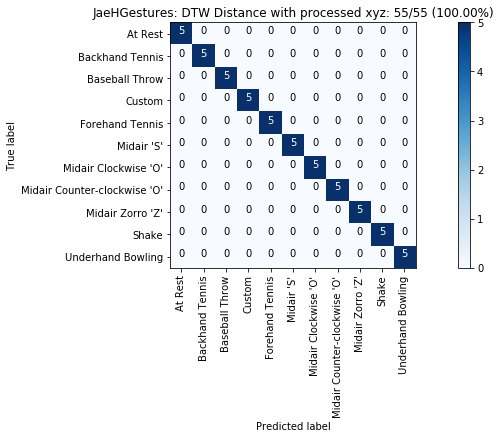

<Figure size 1440x720 with 0 Axes>

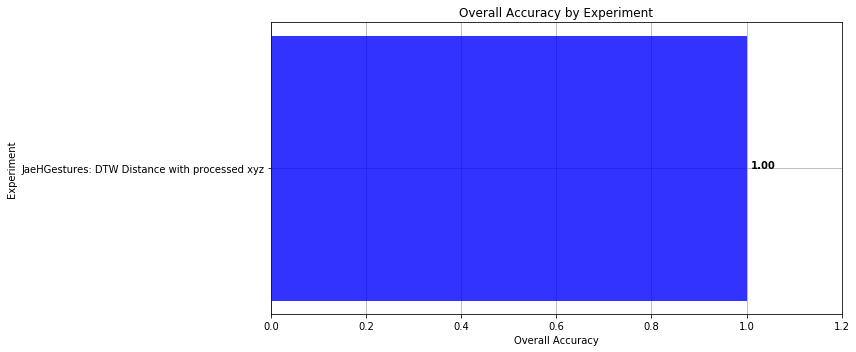

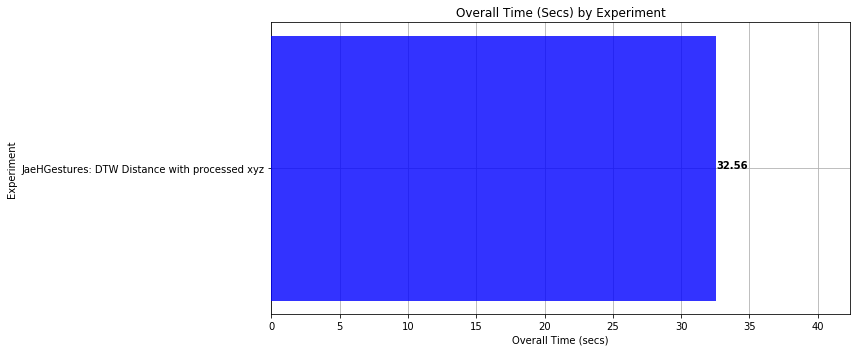

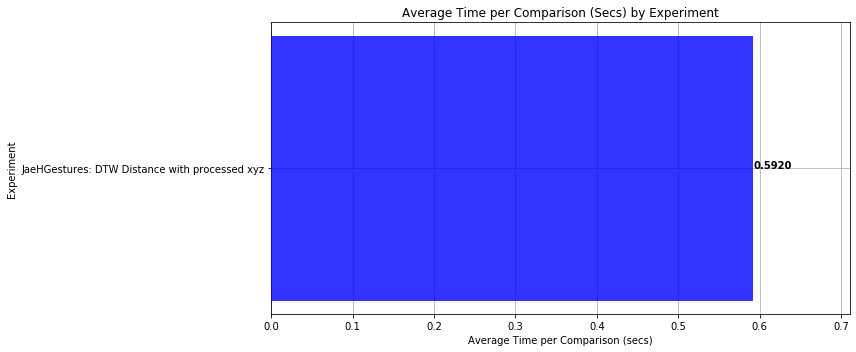

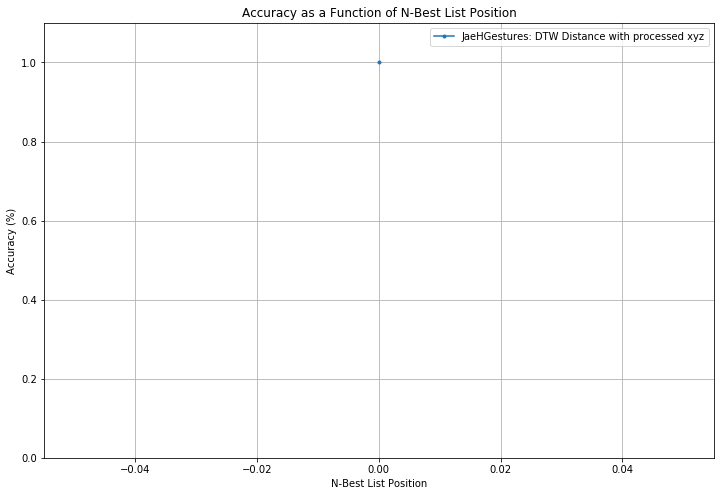

In [193]:
# Generate deliverbles
# Algorithm 1
plot_classification_result_as_confusion_matrix(results_p_dtw)
plot_misclassification(results_p_dtw)

plot_bar_graph_overall_performance(experiments1)
plot_bar_graph_overall_time(experiments1)
plot_bar_graph_avg_time_per_comparison(experiments1)
plot_nbestlist_performance(experiments1)

## Algorithm II - Chi-Squared Alignment

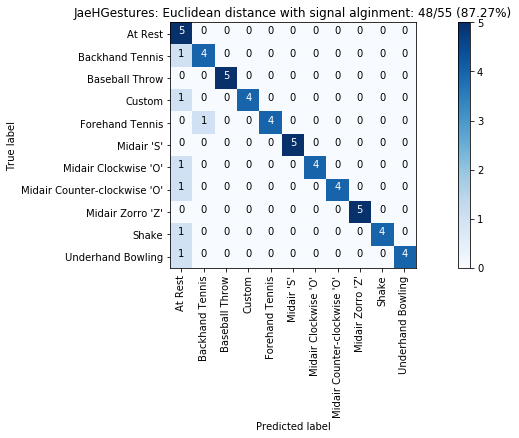

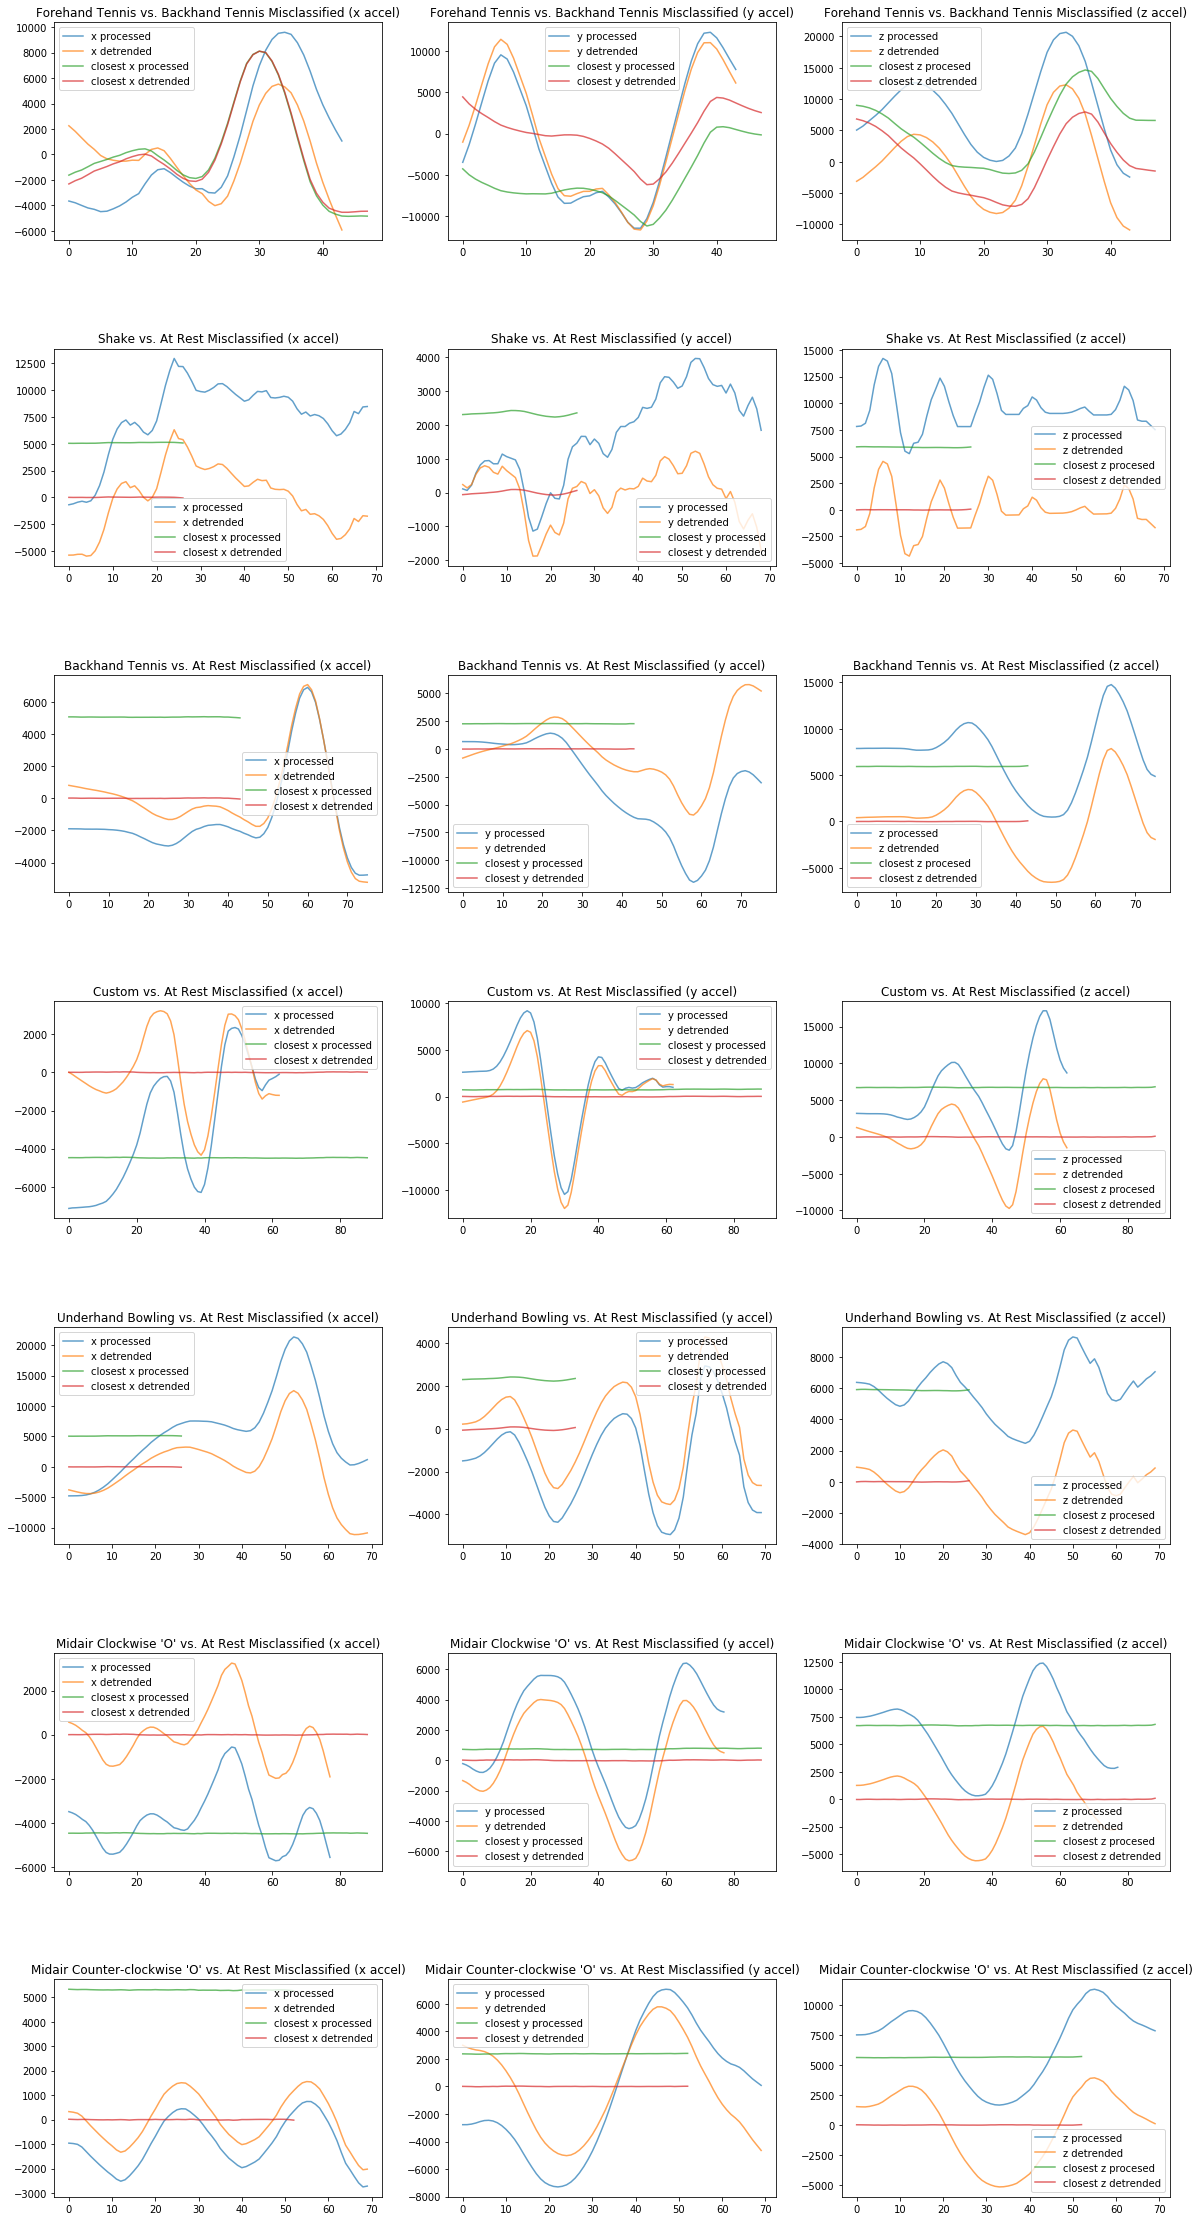

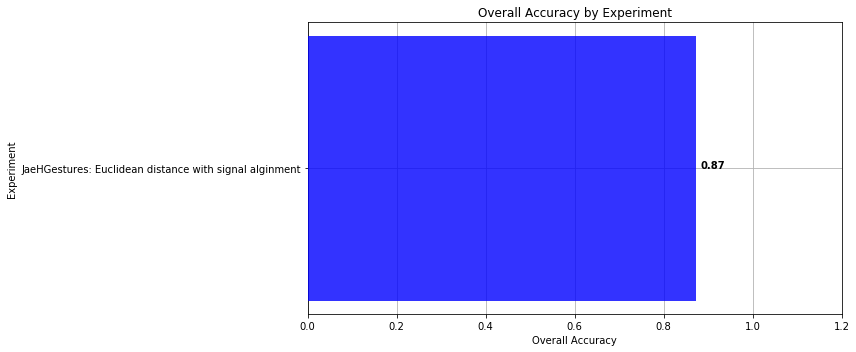

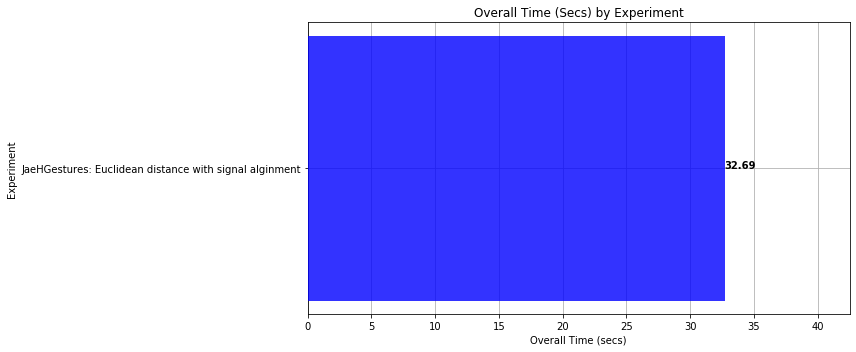

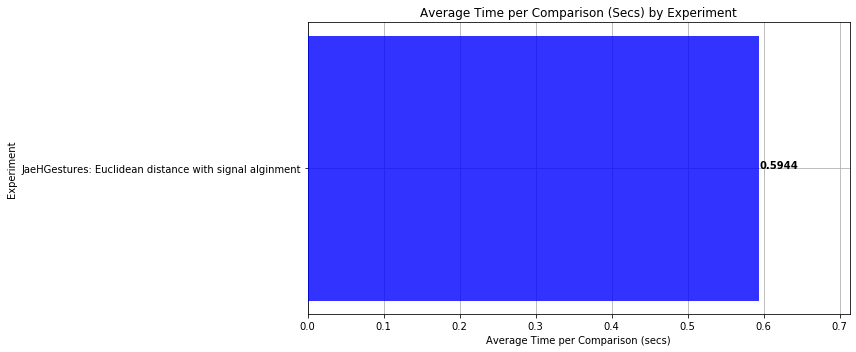

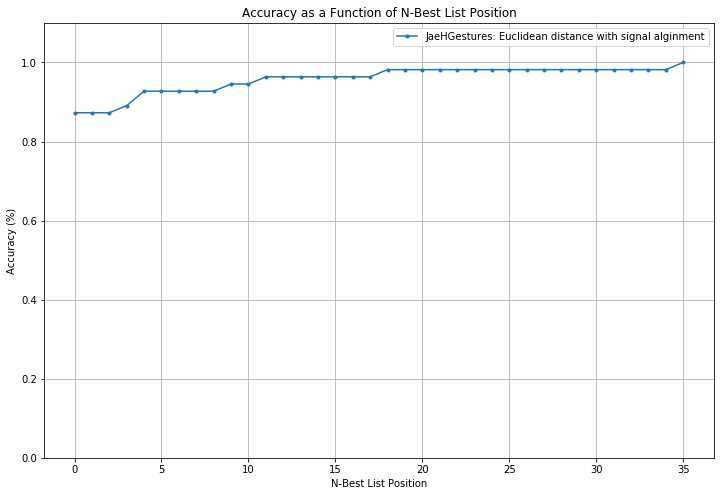

In [21]:
# Algorithm 2
plot_classification_result_as_confusion_matrix(results_chi_sqr_align)
plot_misclassification(results_chi_sqr_align, figsize=(20, 40))

plot_bar_graph_overall_performance(experiments2)
plot_bar_graph_overall_time(experiments2)
plot_bar_graph_avg_time_per_comparison(experiments2)
plot_nbestlist_performance(experiments2)

## Algorithm III - Chi-Squared Alignment and Peak Cnt

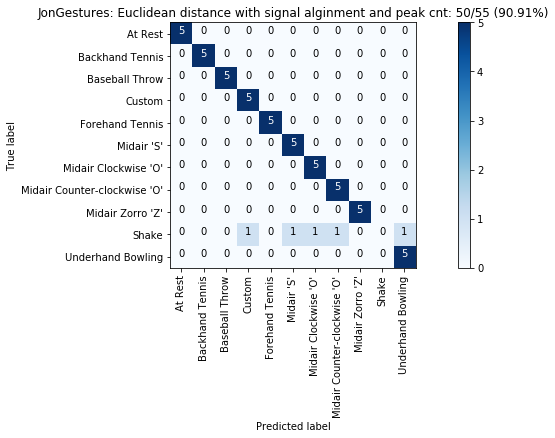

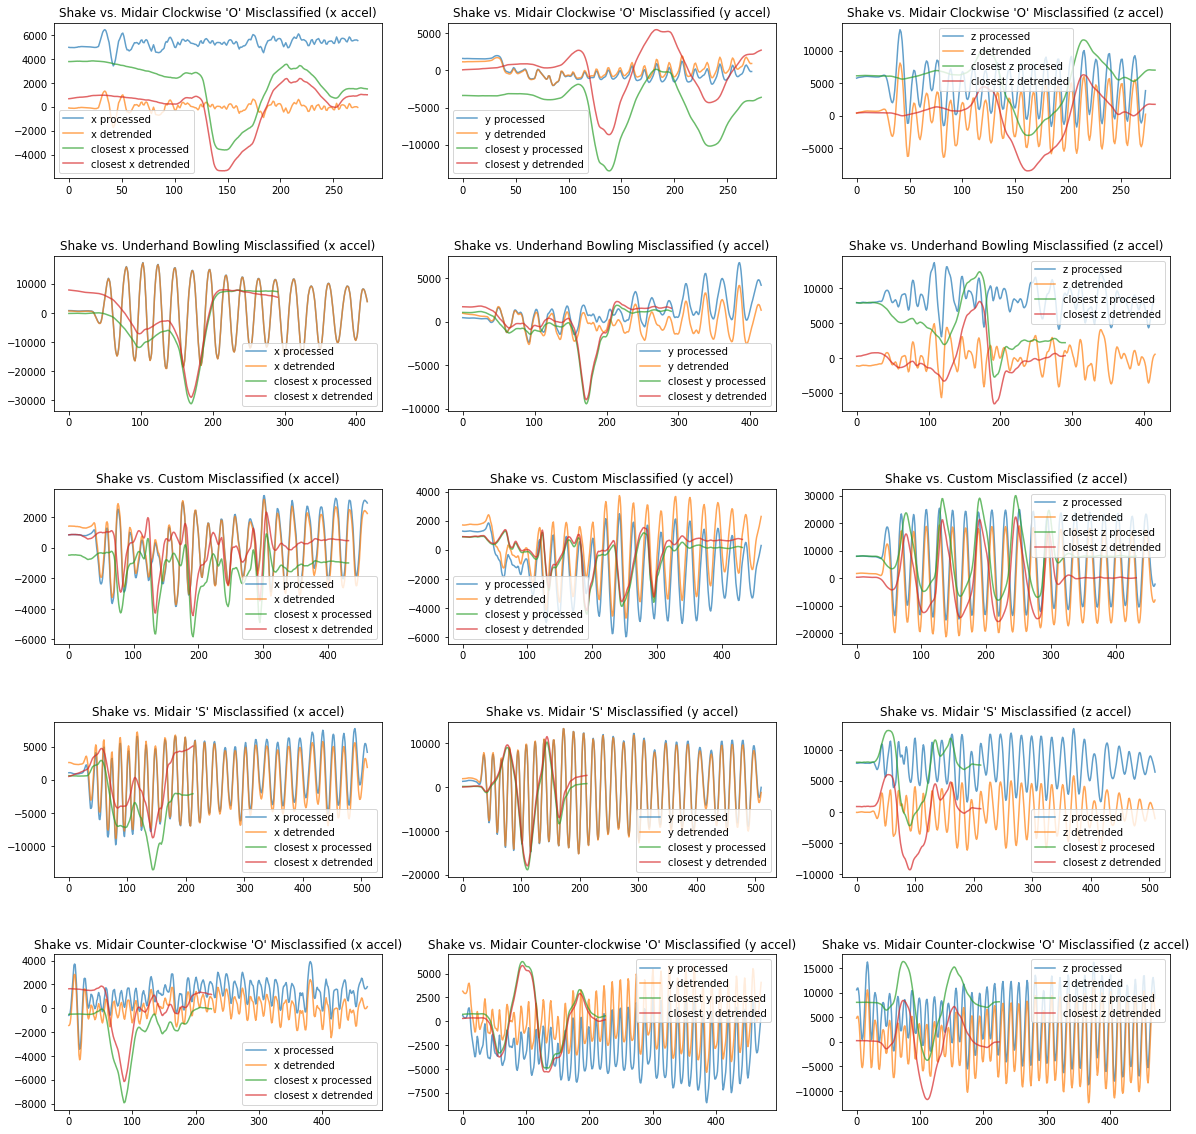

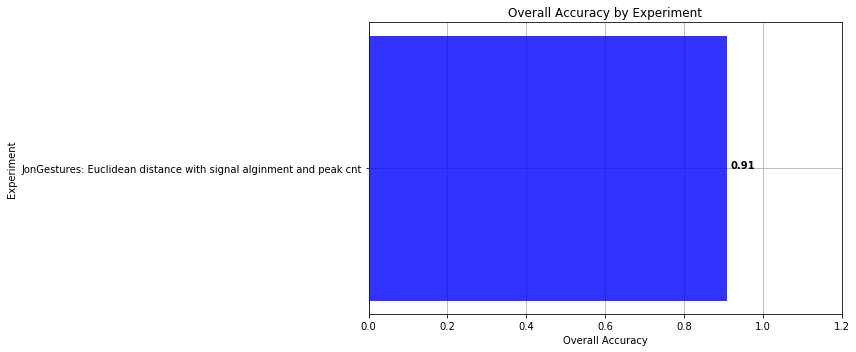

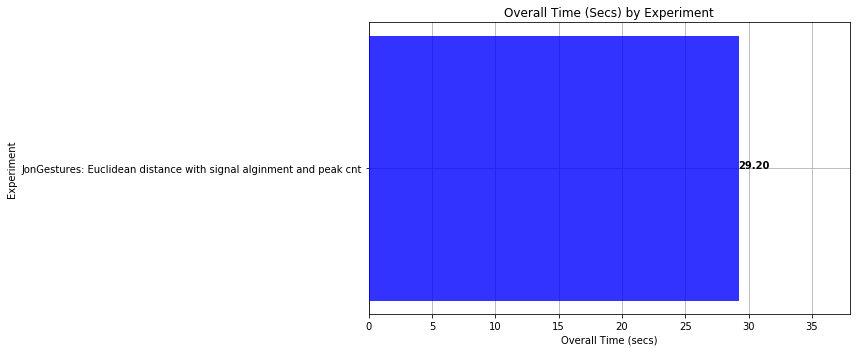

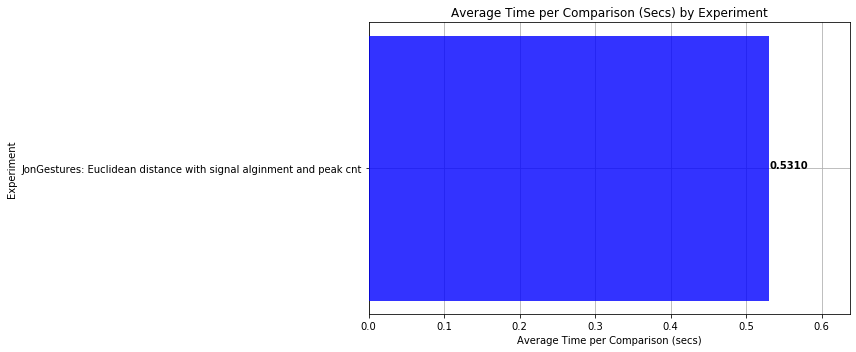

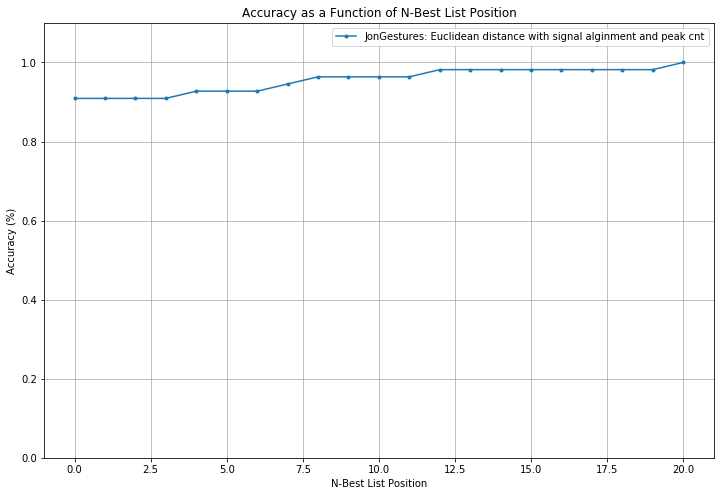

In [162]:
# Algorithm 3
plot_classification_result_as_confusion_matrix(results_chi_sqr_align_peak_cnt)
plot_misclassification(results_chi_sqr_align_peak_cnt, figsize=(20, 20))

plot_bar_graph_overall_performance(experiments3)
plot_bar_graph_overall_time(experiments3)
plot_bar_graph_avg_time_per_comparison(experiments3)
plot_nbestlist_performance(experiments3)

## Algorithm III with Hard dataset

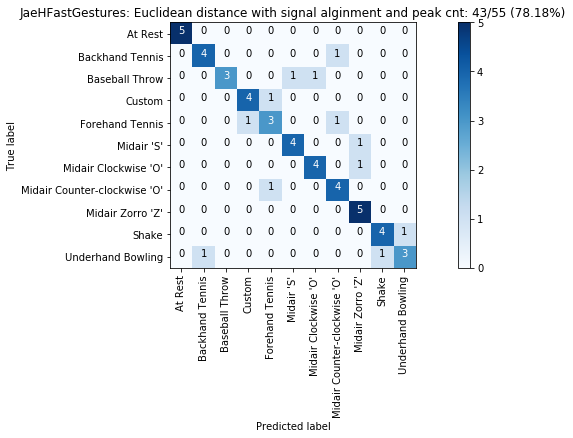

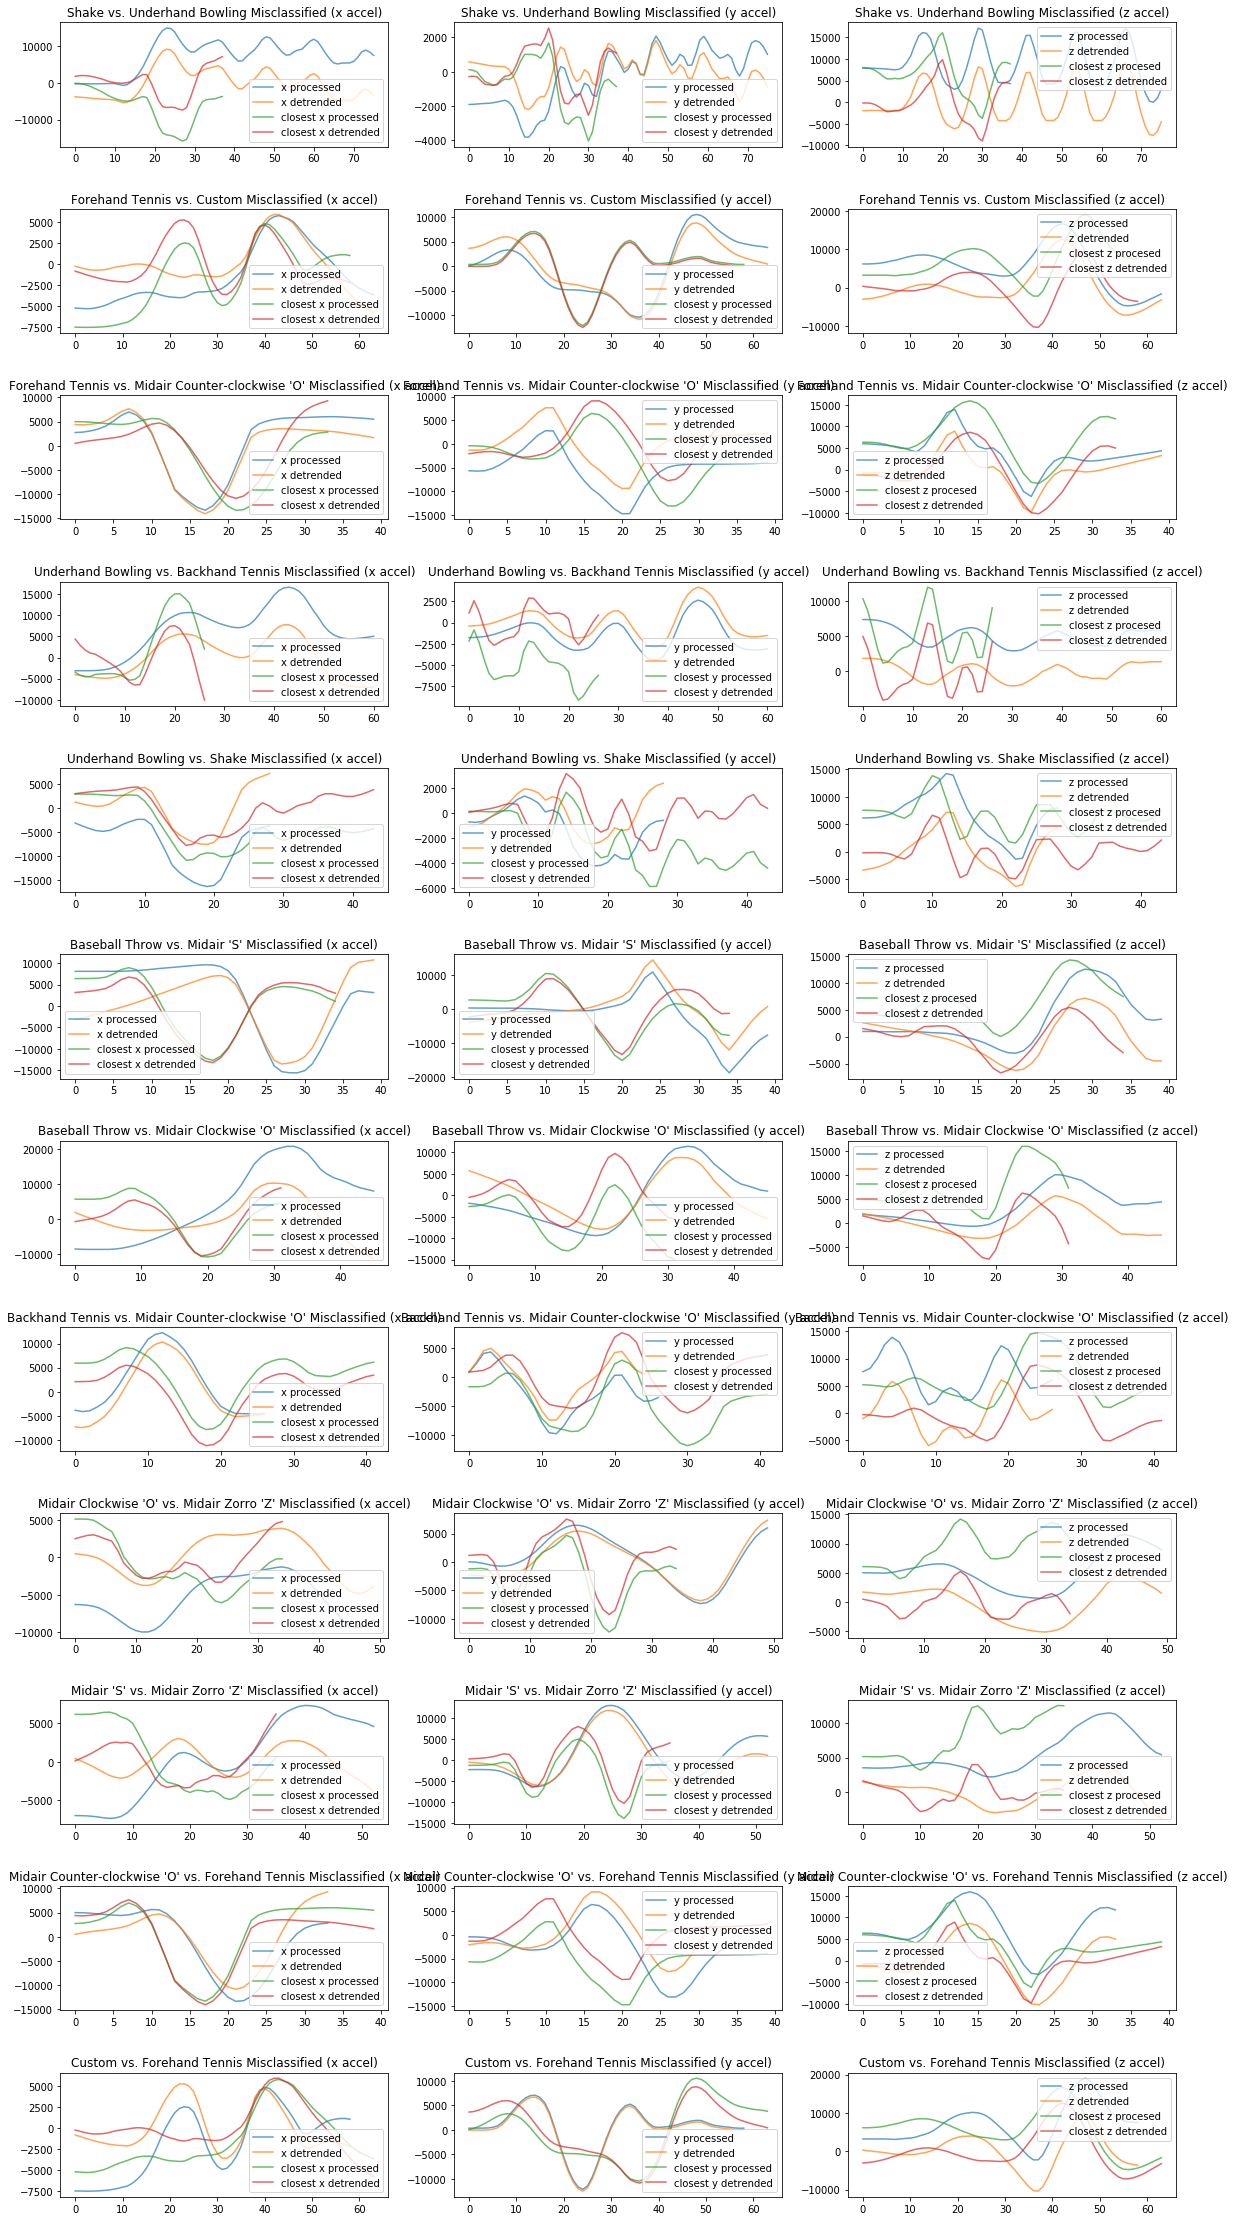

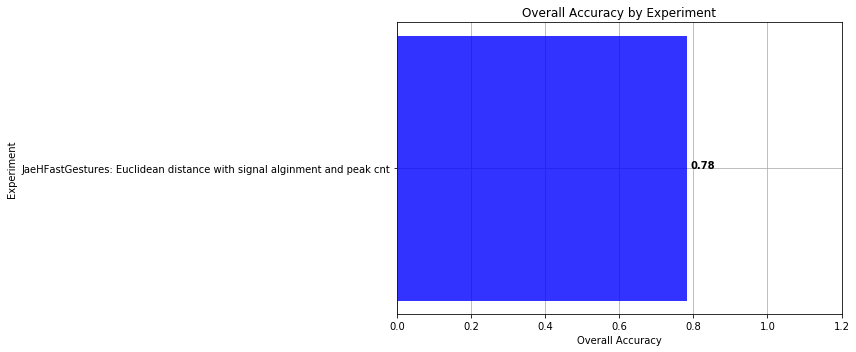

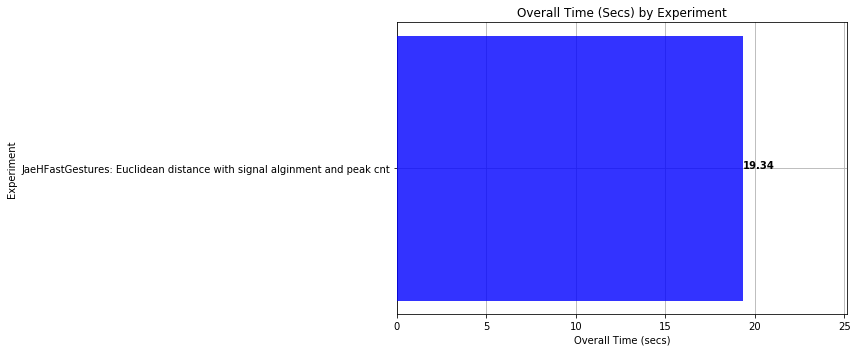

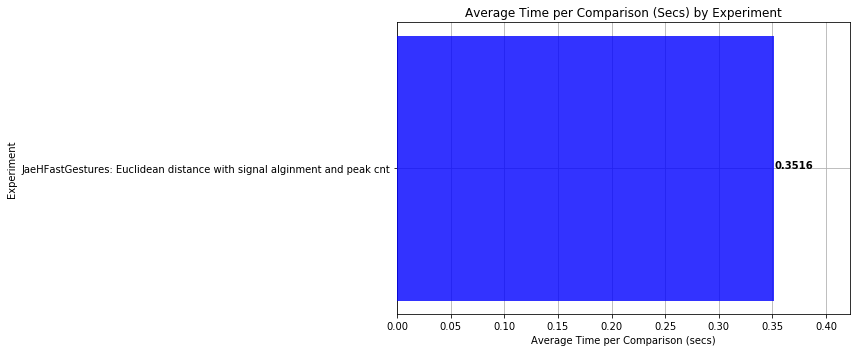

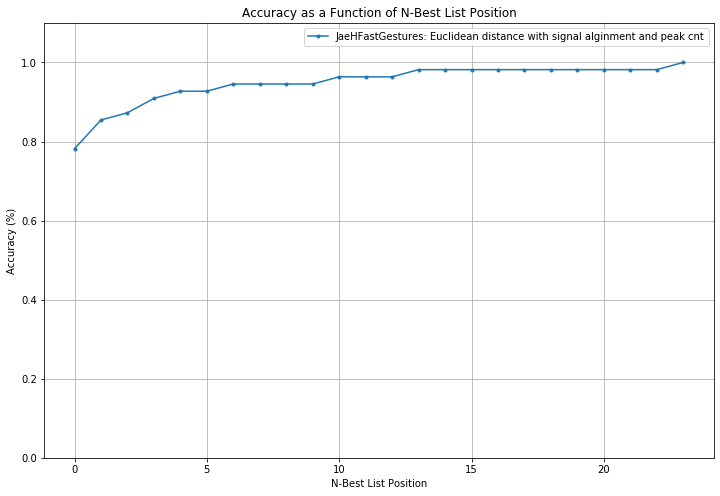

In [172]:
# Generate deliverbles
# Algorithm3
plot_classification_result_as_confusion_matrix(results_chi_sqr_align_peak_cnt)
plot_misclassification(results_chi_sqr_align_peak_cnt, figsize=(20, 40))

plot_bar_graph_overall_performance(experiments4)
plot_bar_graph_overall_time(experiments4)
plot_bar_graph_avg_time_per_comparison(experiments4)
plot_nbestlist_performance(experiments4)

## Algorithm IV - Time Lagged

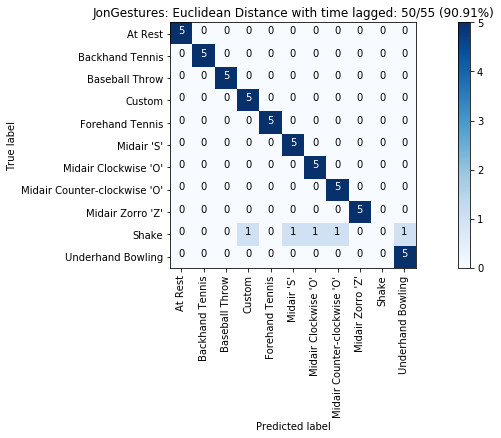

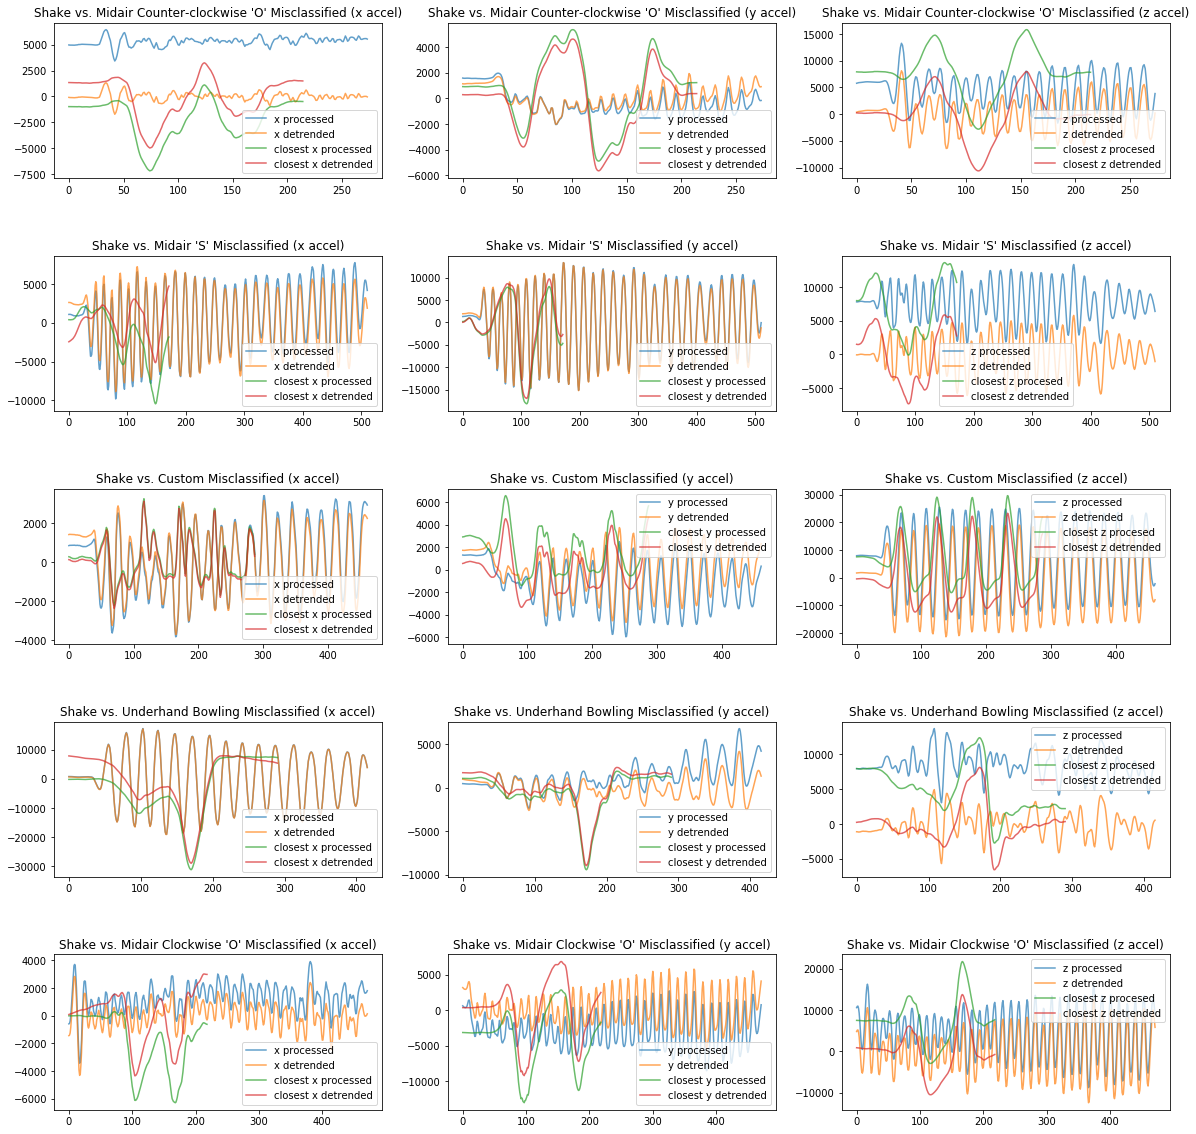

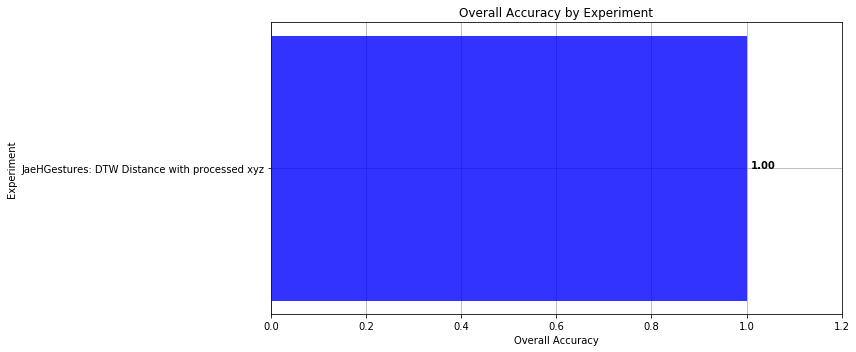

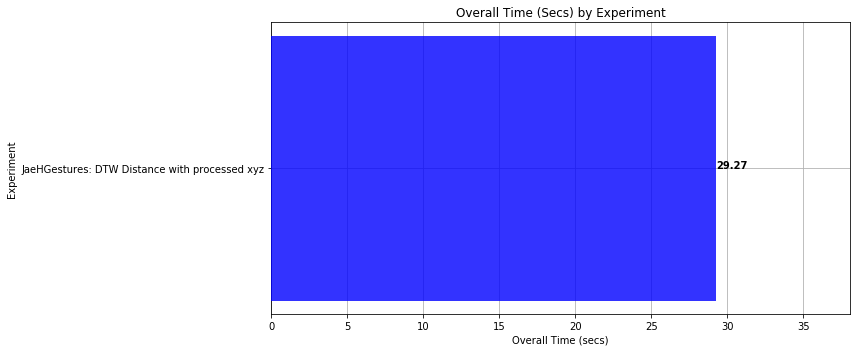

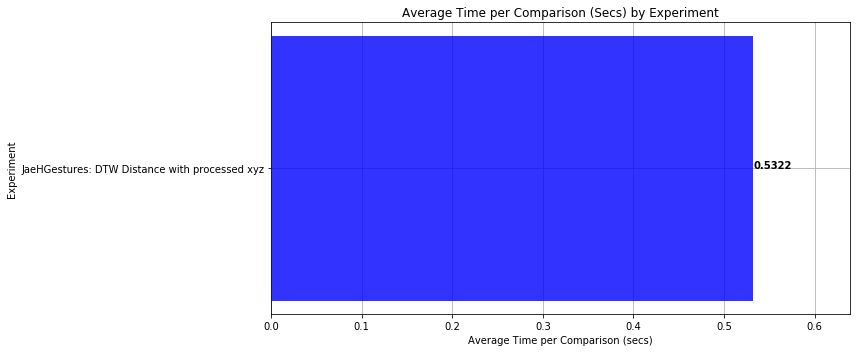

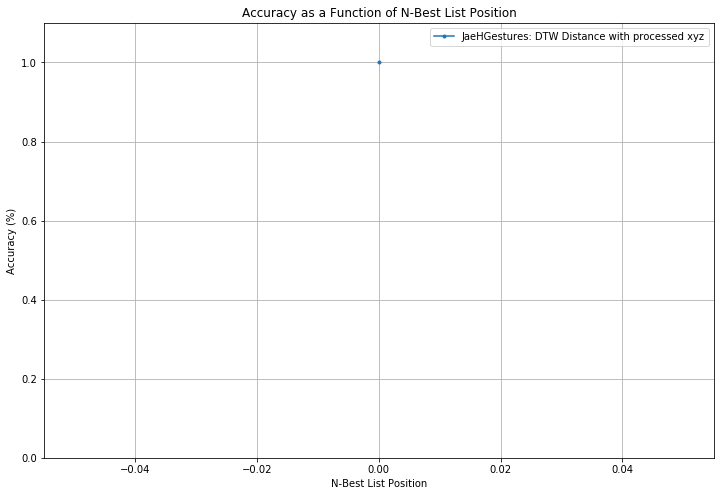

In [94]:
# Generate deliverbles
# Algorithm4
plot_classification_result_as_confusion_matrix(results_p_tl)
plot_misclassification(results_p_tl, figsize=(20, 20))

plot_bar_graph_overall_performance(experiments5)
plot_bar_graph_overall_time(experiments5)
plot_bar_graph_avg_time_per_comparison(experiments5)
plot_nbestlist_performance(experiments5)


# Comparing performance across gesture sets

Gesture Set Name:  NickGestures
Excluding -  NickGestures
Gesture Set Name:  NanGestures

Title: NanGestures: Euclidean distance with time lagged alignment: 50/55 (90.91%)
Optional arguments: {'verbose': False}
Took 29.481s for 55 comparisons (avg=0.536s per match)
- At Rest 5/5 (100.0%)
- Backhand Tennis 4/5 (80.0%)
- Baseball Throw 5/5 (100.0%)
- Custom 4/5 (80.0%)
- Forehand Tennis 5/5 (100.0%)
- Midair 'S' 5/5 (100.0%)
- Midair Clockwise 'O' 5/5 (100.0%)
- Midair Counter-clockwise 'O' 4/5 (80.0%)
- Midair Zorro 'Z' 5/5 (100.0%)
- Shake 4/5 (80.0%)
- Underhand Bowling 4/5 (80.0%)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 1 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 4 1 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 1 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 1 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 1 0 0 0 4]]
Gesture Set Name:  StacyGestures

Title: StacyGestures: Euclidean distance with time lagged alignment: 47/55 (85.45%)
Optional argumen


Title: MikaelGestures: Euclidean distance with time lagged alignment: 54/55 (98.18%)
Optional arguments: {'verbose': False}
Took 7.268s for 55 comparisons (avg=0.132s per match)
- At Rest 5/5 (100.0%)
- Backhand Tennis 5/5 (100.0%)
- Baseball Throw 5/5 (100.0%)
- Custom 5/5 (100.0%)
- Forehand Tennis 5/5 (100.0%)
- Midair 'S' 5/5 (100.0%)
- Midair Clockwise 'O' 5/5 (100.0%)
- Midair Counter-clockwise 'O' 4/5 (80.0%)
- Midair Zorro 'Z' 5/5 (100.0%)
- Shake 5/5 (100.0%)
- Underhand Bowling 5/5 (100.0%)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 1 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 0 5]]
Gesture Set Name:  AlexisGestures

Title: AlexisGestures: Euclidean distance with time lagged alignment: 49/55 (89.09%)
Optional arguments: {'verbose': False}
Took 20.111s for 55 comparisons (avg=0.366s per match)
- A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Title: NooseGestures: Euclidean distance with time lagged alignment: 51/55 (92.73%)
Optional arguments: {'verbose': False}
Took 61.857s for 55 comparisons (avg=1.125s per match)
- At Rest 5/5 (100.0%)
- Backhand Tennis 5/5 (100.0%)
- Baseball Throw 5/5 (100.0%)
- Custom 5/5 (100.0%)
- Forehand Tennis 5/5 (100.0%)
- Midair 'S' 4/5 (80.0%)
- Midair Clockwise 'O' 4/5 (80.0%)
- Midair Counter-clockwise 'O' 4/5 (80.0%)
- Midair Zorro 'Z' 5/5 (100.0%)
- Shake 5/5 (100.0%)
- Underhand Bowling 4/5 (80.0%)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 4 1 0 0 0 0]
 [0 0 0 0 0 0 4 1 0 0 0]
 [0 0 0 0 0 0 1 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 1 0 0 0 0 0 0 4]]
Gesture Set Name:  EmmaGestures


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Title: EmmaGestures: Euclidean distance with time lagged alignment: 48/55 (87.27%)
Optional arguments: {'verbose': False}
Took 8.017s for 55 comparisons (avg=0.146s per match)
- At Rest 5/5 (100.0%)
- Backhand Tennis 5/5 (100.0%)
- Baseball Throw 5/5 (100.0%)
- Forehand Tennis 4/5 (80.0%)
- Midair 'S' 5/5 (100.0%)
- Midair Clockwise 'O' 3/5 (60.0%)
- Midair Counter-clockwise 'O' 2/5 (40.0%)
- Midair Zorro 'Z' 5/5 (100.0%)
- Shake 5/5 (100.0%)
- Star 5/5 (100.0%)
- Underhand Bowling 4/5 (80.0%)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 1 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 2]
 [0 0 0 1 0 0 2 0 0 0 2]
 [0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 1 0 0 0 4]]
Gesture Set Name:  BrettGestures


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Title: BrettGestures: Euclidean distance with time lagged alignment: 37/55 (67.27%)
Optional arguments: {'verbose': False}
Took 70.089s for 55 comparisons (avg=1.274s per match)
- At Rest 5/5 (100.0%)
- Backhand Tennis 3/5 (60.0%)
- Baseball Throw 4/5 (80.0%)
- Custom 2/5 (40.0%)
- Forehand Tennis 3/5 (60.0%)
- Midair 'S' 5/5 (100.0%)
- Midair Clockwise 'O' 2/5 (40.0%)
- Midair Counter-clockwise 'O' 4/5 (80.0%)
- Midair Zorro 'Z' 5/5 (100.0%)
- Shake 2/5 (40.0%)
- Underhand Bowling 2/5 (40.0%)
[[5 0 0 0 0 0 0 0 0 0 0]
 [0 3 1 0 0 0 0 0 0 0 1]
 [0 0 4 0 0 0 0 0 0 1 0]
 [0 0 0 2 1 0 0 0 0 2 0]
 [0 1 0 0 3 0 0 0 0 0 1]
 [0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 2 3 0 0 0]
 [0 0 0 0 0 0 1 4 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0]
 [0 0 1 1 0 0 0 0 1 2 0]
 [0 1 0 0 2 0 0 0 0 0 2]]
Average accuracy: 0.9174242424242424 Stdev=0.08130803359389167


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:133: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


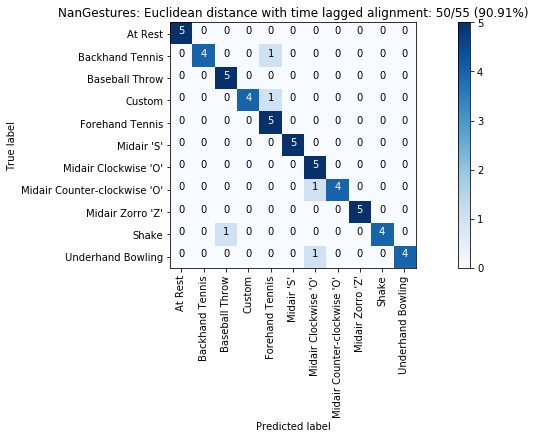

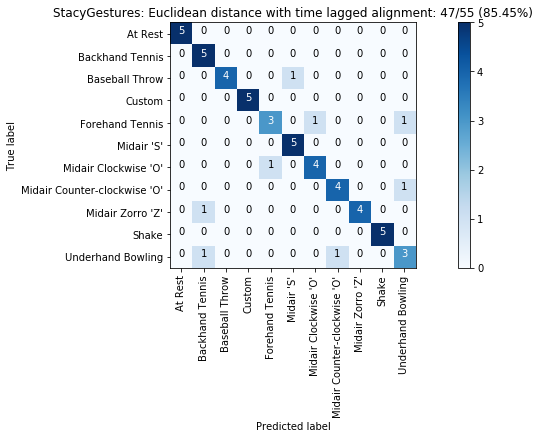

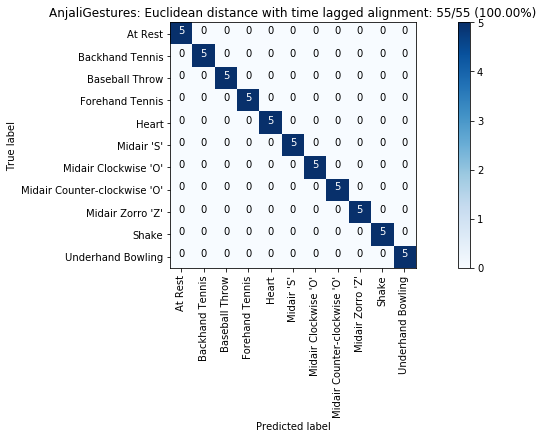

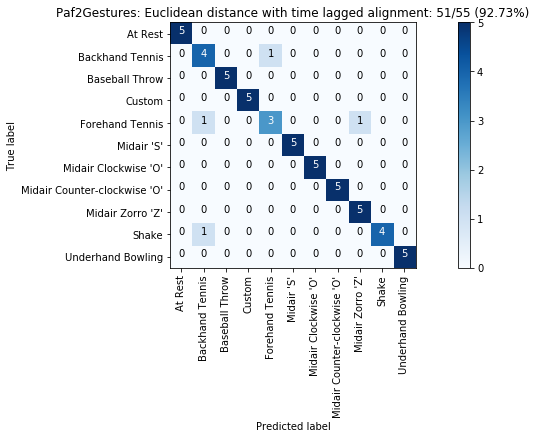

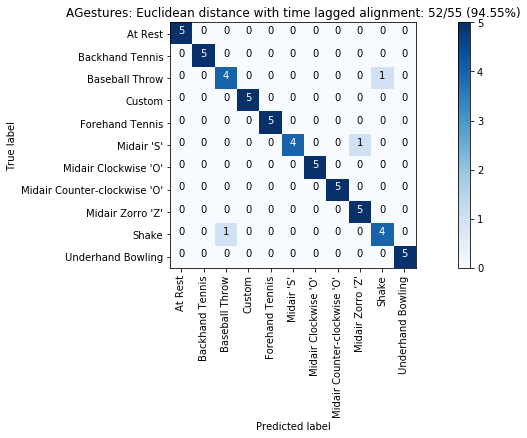

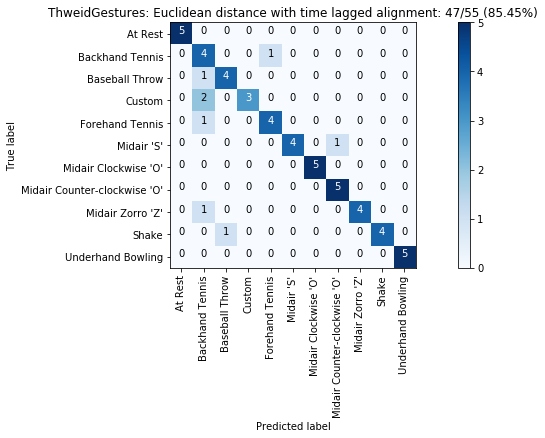

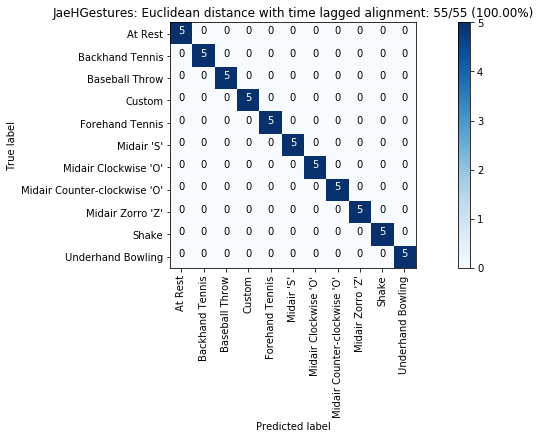

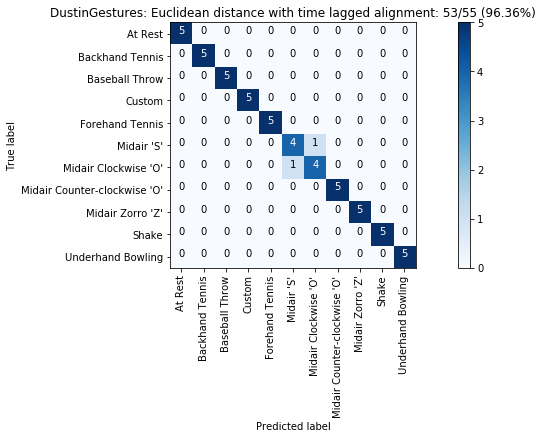

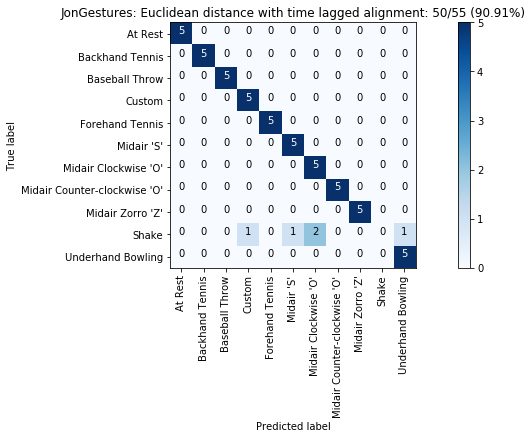

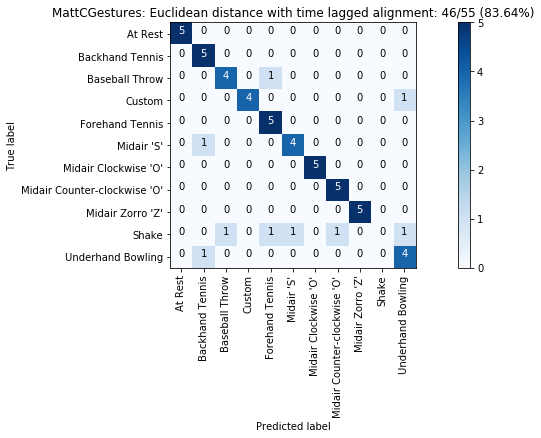

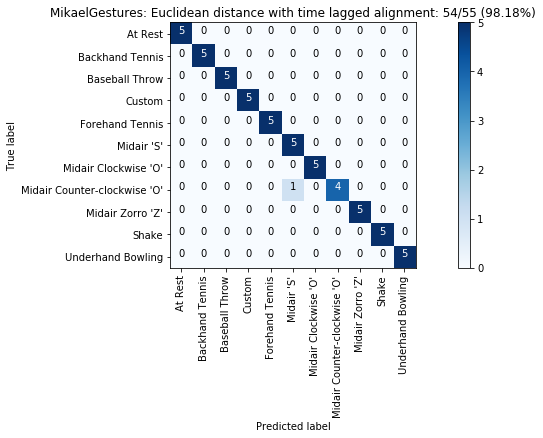

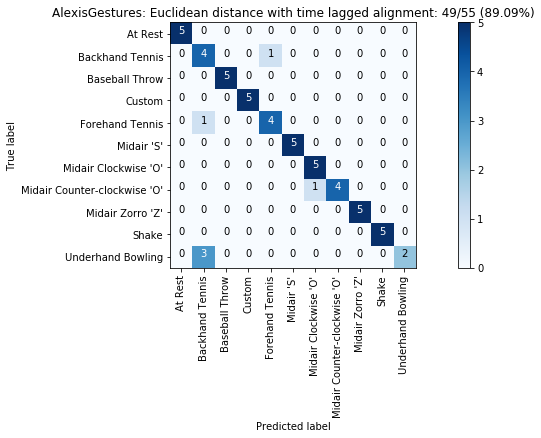

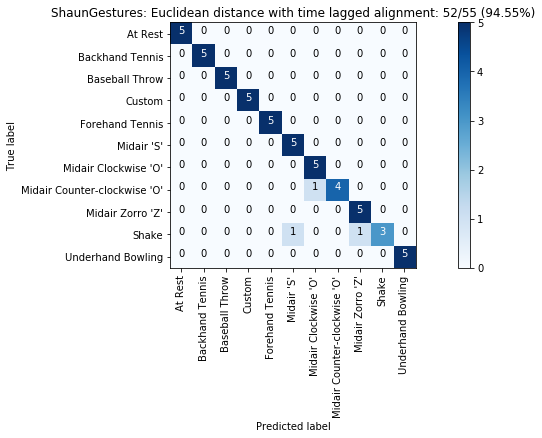

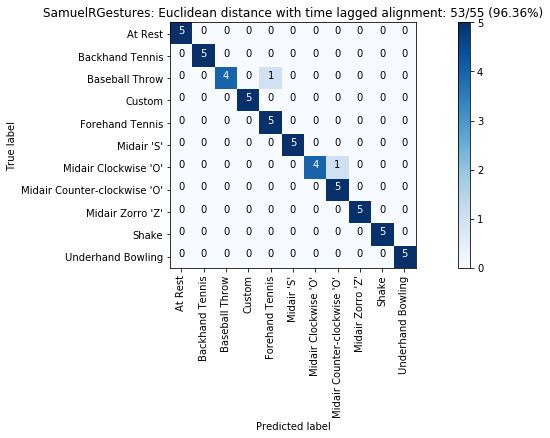

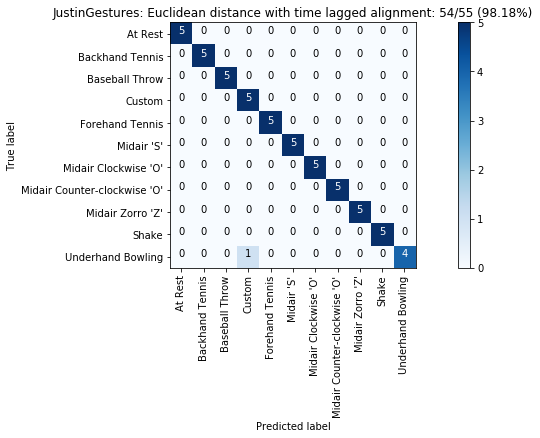

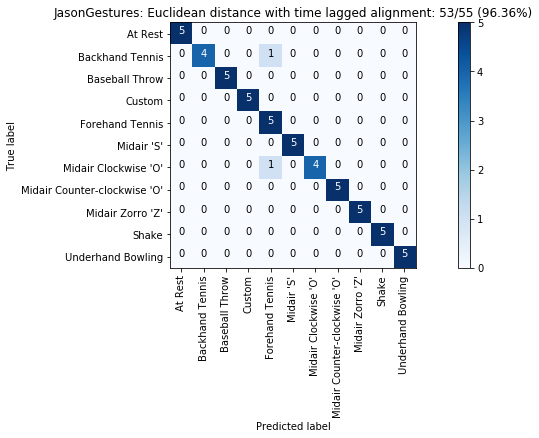

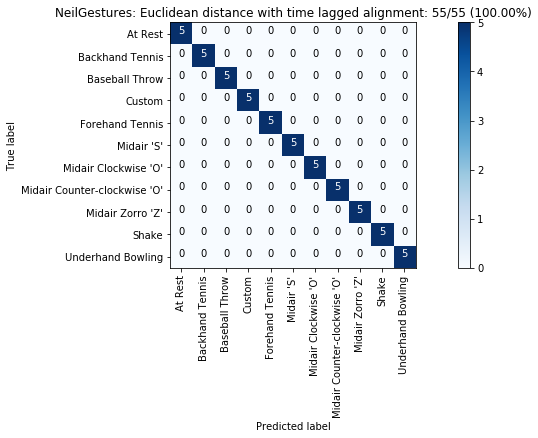

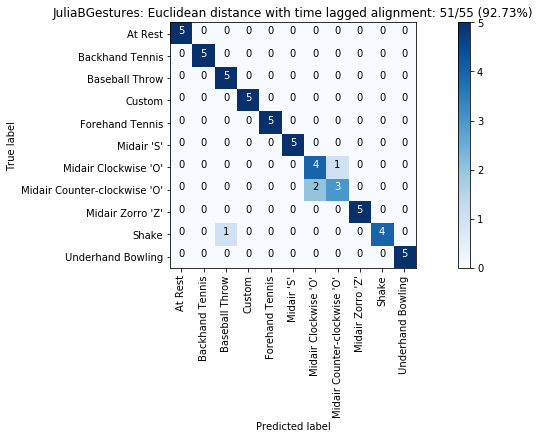

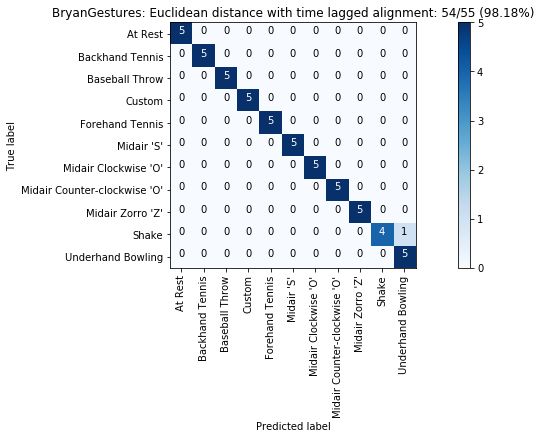

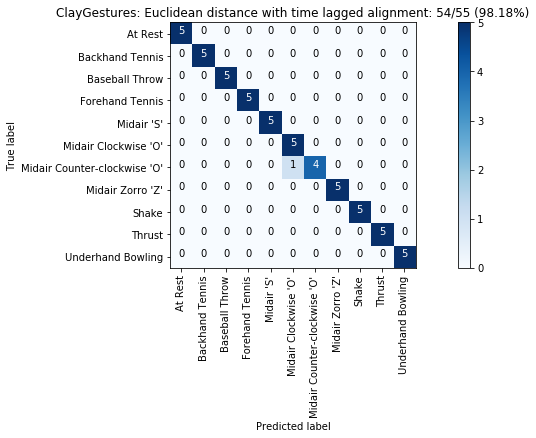

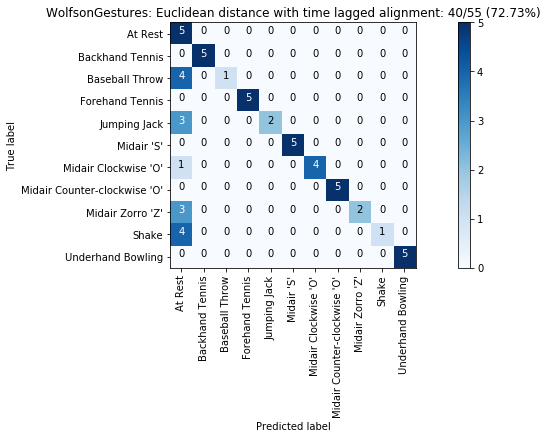

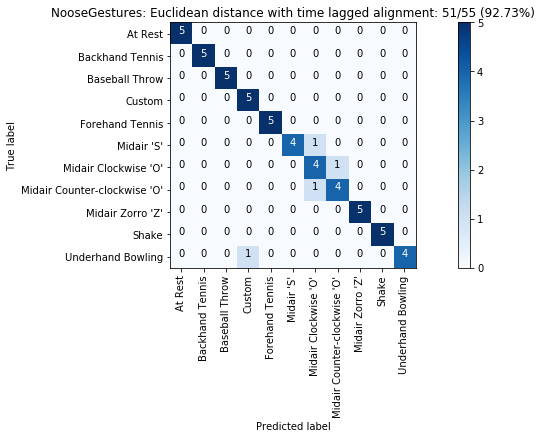

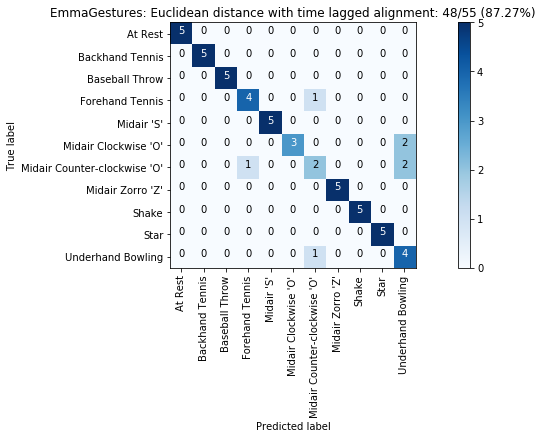

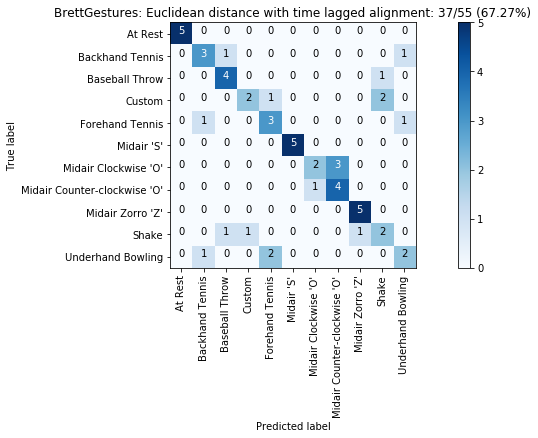

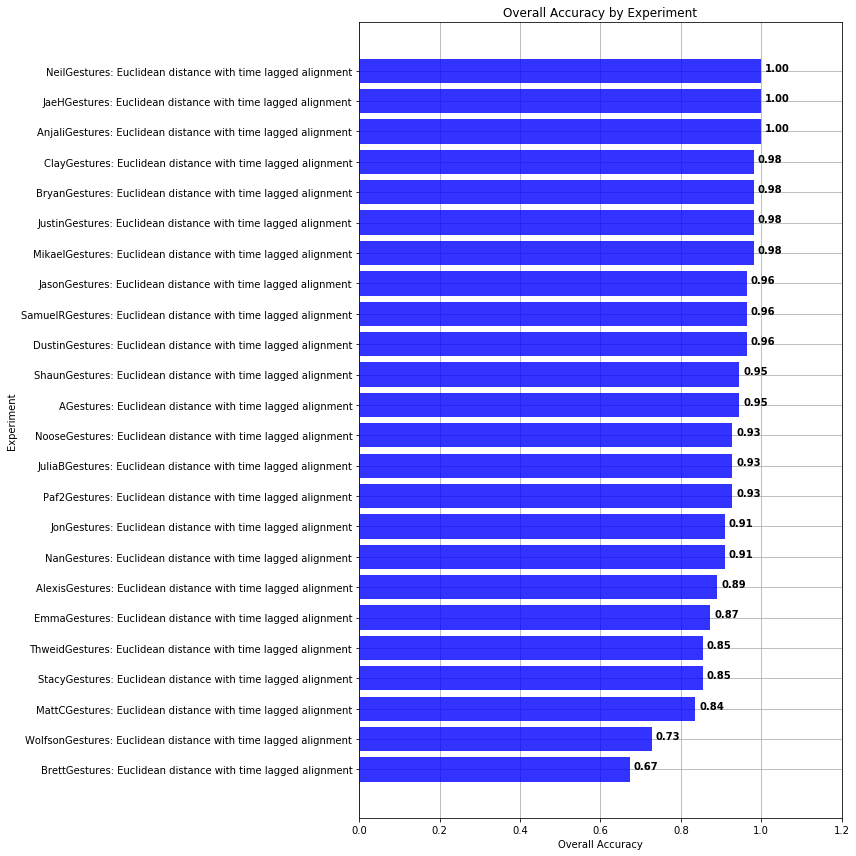

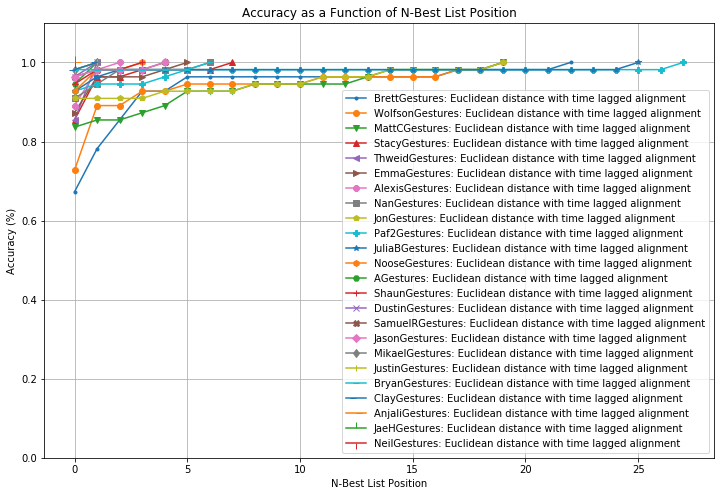

In [97]:
# track multiple experiments
experiments = Experiments()
exclude = ['NickGestures']
# Run experiments across all gesture sets
for gesture_set_name, gesture_set in map_gesture_sets.items():
    print("Gesture Set Name: ", gesture_set_name)
    if gesture_set_name in exclude:
        print("Excluding - ", gesture_set_name)
        continue
    list_folds = generate_kfolds_scikit(5, gesture_set, seed=5) 
    
    # run initial experiment
    results = run_matching_algorithm(list_folds, find_closest_match_p_signal_time_lagged, verbose=False)
    results.title = "{}: Euclidean distance with time lagged alignment".format(gesture_set.name)
    results.print_result()
    
    plot_classification_result_as_confusion_matrix(results)
    experiments.add(results)

avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")
plot_bar_graph_overall_performance(experiments)
plot_nbestlist_performance(experiments)

In [98]:
avg_accuracy, stddev = experiments.get_avg_accuracy_with_std()
print(f"Average accuracy: {avg_accuracy} Stdev={stddev}")

Average accuracy: 0.9174242424242424 Stdev=0.08130803359389167


# Experiment Result

I have developed three gesture recognition algorithms. Initially, I studied the various preprocessing options such as offset translation, amplitude scaling, detrending, etc. Then I picked a couple of options that showed some accuracy improvements for the provided matching methods. As developing algorithms, I experimented them with the selected configurations and the summaries are shown below.

|Algorithm| Convolve  | Preprocessing | Dataset | Accuracy  | Note  |
|:---:|:---:|:---:|:---:|:---:|:---:|
|I|5   | offset translation  | Jon  | 96.36   | Limited to Shake  |
|I|5   | amplitude scaling  | Jon  | 90.91   | better for shake, but no good for at rest  |
|I|5   |detrending  | Jon  | 96.36   | two missing shake cases  |
|I|10   |detrending  | Jon  | 98.18   | one missing shake case  |
|I|10   |detrending  | JaeH  | 100   | -  |
| II |10   | detrending  | JaeH  |  89.09  | -  |
| II |5   | No detrending  | JaeH  |  90.91  | better with no detrending  |
| II |10   | No detrending  | JaeH  | 94.55   | better with larger mean filter window  |
| II |5   | No detrending  | Jon  | 74.55   | -  |
| II |10   | No detrending  | Jon  |  76.36  | better with larger mean filter window  |
| III |10   | No detrending  | Jon  |  90.91  | improved from 76.36% with Algorithm II  |
| III |10   | No detrending  | JaeH  | 98.18   | improved from 94.5% with Algorithm II  |
| IV |10   | No detrending  | Jon  |  90.91  | improved from 76.36% with Algorithm II, but confusing with 'Shake'  |
| IV |10   | No detrending  | JaeH  | 100.00  | improved from 94.5% with Algorithm II  |

Based on the several observations, I decided to use dynamic time warping(DTW) so that I can compare the signals with different length without losing the characteristics of signals. Using the `fastdtw` libaray, I was easily able to achieve the highest accuracy within reasonable time. And the algorithm gave **the 97% of accuracy for all class dataset**. Using wider mean filtering window helped improve the accuracy little bit more as well, specially for some dataset with rough signal. However, the algorithm often predicted some obvious case such as `Shake` or `Baseball Throw` as the `At Rest`, which made me to consider alginment based approach.

The algorithm II is based on the `chi-squared` alginment. Basically, it finds the offset where the area between two signals is minimum. I used the library found in github for the implementation (its link is commented in source code). The approach actually didn't work well. Specially for the `Jon` dataset, the accuracy was dropped to below 80%. And the overall accuray for all classmates were **87%**. One thing I noticed was the algorithm was clearly confused the `Shake` case with `At Rest`. To understand more details, I implemented the method that plots all misclassified cases (see powerpoint). Looking at the plots, it didn't make sense why the method classify the `Shake` as `At Rest`. 

So I came up with the approach with a peak count factor. It basically amplifies the `euclidean distance` after the `chi-squared alignment` by the peak count * delta between maximum and minimum of signal. For example, for `At Rest`, the peak count might be similar to `Shake`, but the delta between maximum and minimum of signal is much smaller. So it will give higher probability of avoding the misclassification found in Algorithm II. The approach was successful in that the accuracy was improved from **87%** to **91%** for the all classmates.

After I wrapped up those experiements and results, I wondered how robust the methods were against **Hard** dataset. So while collecting a new dataset, I intentionally added some noise to each case with speed. It turned out, as expected, the both algorithm I and III dropped the accuracy to below 80%. Basically, DTW methods wasn't robust enough to classify the dataset with hard-noise. And the misclassification plots shows that it confused between `Backhand Tennis` with other cases. The algorithm III also showed the similar lower accuracy, but it was weak to the shaping cases, such as `Z` and `O`.

As the final trials, I also wanted to try out the time lagged algorithm. I implemented Algorithm IV and went through the experiments. The resuls got improved from Algorithm III but still lower than DTW (Algorithm I). 

Finally, this homework is well designed for student to learn the pattern matching. From actual data collection, to visualize data, and to develop algorithms for classification, each step helped me to learn and explore new topics. I think the framework can be improved by allowing user to normalize the cost parameters(euclidean distance, num of peaks, etc.). Currently we are limited to a single value, i.e., euclidean distance. For example, if I wanted to classify the case based on the euclidean distance and number of peaks raito, we are limited to the same weight (for the python sorting of tuples). 